Trains and  tests on parts of  NA12878 data for Del_st, Del_end and No_sv, ground  truth Mills_nanosv

## Load dependences and setting output configuration

In [1]:
import numpy as np
from keras.utils.np_utils import to_categorical
import keras
%pylab inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


## Load data from npy files

In [2]:
import pickle
dico = pickle.load(open("F:/1_GTCG/data/11092018/labels.pickle/labels.pickle", "rb"))
data_labels = dataset = dico["Mills2011_nanosv"]
window_size = 200

In [3]:
dico = []

In [4]:
replications = 64
factor_nosv = 1 # factor_nosv times less Nosv than del-st

In [5]:
datapath = 'F:/1_GTCG/data/TestData_060818.tar/TestData_060818/NA12878' 

germline_1_datapath = datapath + '/ChannelData/unzipped/'
#ger_1_labels_datapath = datapath + '/LabelData/unzipped/'

G1_data_SV = np.empty([0, 27, window_size])
G1_labels_SV =[]
G1_data_noSV = np.empty([0, 27, window_size])
G1_labels_noSV =[]
total_train_sv_windows = 0
for i in range(1,23,1):
        G1_data_new =np.load(germline_1_datapath + str(i) + '_channel_maker_real_germline.npy/' + str(i) +'_channel_maker_real_germline.npy')
        #G1_labels_new = np.load(ger_1_labels_datapath  +  str(i) +'_label_ci_full_overlap.npy/' +str(i) +'_label_ci_full_overlap.npy') 
        G1_labels_new = np.array(data_labels[str(i)])
        print(G1_labels_new[0])
        G1_data_new = G1_data_new[np.where(G1_labels_new != 'UK')]
        G1_labels_new = G1_labels_new[np.where(G1_labels_new != 'UK')]
        G1_data_SV_new  = G1_data_new[np.where(G1_labels_new != 'noSV')]
        G1_labels_SV_new  = G1_labels_new[np.where(G1_labels_new != 'noSV')]
        n_windows_sv = G1_data_SV_new.shape[0]
        G1_data_noSV_new  = G1_data_new[np.where(G1_labels_new == 'noSV')]
        G1_labels_noSV_new  = G1_labels_new[np.where(G1_labels_new == 'noSV')]
        G1_data_noSV_new =  G1_data_noSV_new[0:int(replications*n_windows_sv/2/factor_nosv)]# 4 times less than del_st to boost recall
        G1_labels_noSV_new =  G1_labels_noSV_new[0:int(replications*n_windows_sv/2/factor_nosv)] # also
        print(str(i) + ':' + str(G1_data_SV_new.shape))
        #print(G1_labels_SV_new[0])
        G1_data_SV = np.concatenate((G1_data_SV, G1_data_SV_new))
        G1_labels_SV = np.concatenate((G1_labels_SV, G1_labels_SV_new))
        G1_data_noSV = np.concatenate((G1_data_noSV, G1_data_noSV_new))
        G1_labels_noSV = np.concatenate((G1_labels_noSV, G1_labels_noSV_new))
        if i < 16: #for training until chromozome 16
            total_train_sv_windows += G1_data_SV_new.shape[0]

noSV
1:(222, 27, 200)
noSV
2:(205, 27, 200)
noSV
3:(208, 27, 200)
noSV
4:(228, 27, 200)
noSV
5:(214, 27, 200)
noSV
6:(162, 27, 200)
noSV
7:(163, 27, 200)
noSV
8:(135, 27, 200)
noSV
9:(127, 27, 200)
noSV
10:(107, 27, 200)
noSV
11:(119, 27, 200)
noSV
12:(114, 27, 200)
noSV
13:(106, 27, 200)
noSV
14:(66, 27, 200)
noSV
15:(61, 27, 200)
noSV
16:(47, 27, 200)
noSV
17:(48, 27, 200)
noSV
18:(77, 27, 200)
noSV
19:(44, 27, 200)
noSV
20:(58, 27, 200)
noSV
21:(28, 27, 200)
noSV
22:(21, 27, 200)


### Find  the indexes that split the categories

In [6]:
def find_splitting_indices(labels):
    for i in range (0, labels.shape[0] - 1):
        if (labels[i] != labels[i+1]):
            print(i , ': ', labels[i] , labels[i+1] )        

In [7]:
#find_splitting_indices(G1_labels)

In [8]:
#G1_labels_SV = ['DEL'] * G1_labels_SV.shape[0]

In [9]:
sv=G1_data_SV.shape[0]

In [10]:
sv

2560

In [11]:
int(sv/2)

1280

In [12]:
nosv = G1_data_noSV.shape[0]
nosv

81920

In [13]:
#G1_data_noSV  = G1_data_noSV[0:2*sv] 

In [14]:
#G1_labels_noSV  = G1_labels_noSV[0:2*sv] 

In [15]:
SV_train =  int(0.8 * total_train_sv_windows)
noSV_train = int(replications * SV_train / 2/factor_nosv)
SV_val = total_train_sv_windows - SV_train
noSV_val = int(replications * SV_val / 2/factor_nosv)

In [16]:
def replicate(data, start, end, howmanytimes): 
    X = data[start:end]
    for i in range(0,howmanytimes):
        X = np.concatenate((X, data[start:end]))
    return X    
    

In [17]:

X_train = replicate(G1_data_SV, 0, SV_train, replications)
y_train = replicate(G1_labels_SV, 0, SV_train,replications)
X_val = replicate(G1_data_SV, SV_train, SV_train+SV_val, replications)
y_val = replicate(G1_labels_SV, SV_train, SV_train+SV_val, replications)
X_test = replicate(G1_data_SV, SV_train+SV_val, len(G1_data_SV), replications)
y_test = replicate(G1_labels_SV, SV_train+SV_val, len(G1_labels_SV), replications)

In [18]:
X_train = np.concatenate((X_train, G1_data_noSV[0:noSV_train ]))
X_val = np.concatenate((X_val, G1_data_noSV[noSV_train:noSV_train +noSV_val ]))
X_test = np.concatenate((X_test, G1_data_noSV[noSV_train +noSV_val:]))

In [19]:
y_train = np.concatenate((y_train, G1_labels_noSV[0:noSV_train ]))
y_val = np.concatenate((y_val, G1_labels_noSV[noSV_train:noSV_train +noSV_val ]))
y_test = np.concatenate((y_test, G1_labels_noSV[noSV_train +noSV_val:]))

### Number of training, validation and test windows

In [20]:
X_train.shape

(173533, 27, 200)

In [21]:
X_val.shape

(43456, 27, 200)

In [22]:
X_test.shape

(31331, 27, 200)

In [23]:
y_test.shape

(31331,)

In [24]:
number_channels = X_train.shape[1]
number_channels

27

## Normalize data using the reads coverage as parameter and remove uninteresting channels for deletions

In [25]:
coverage = np.median(X_train[:, 0, :]) #the median of the coverage in the normal cells
coverage


34.0

In [26]:
def normalize(X):       
    for i in range (0, len(X)):                              
        for j in range(0,number_channels):                                                                                            
            X[i][j] = np.divide(X[i][j], coverage)*100 
normalize(X_train)
normalize(X_val)
normalize(X_test)

In [27]:
def eliminate_noise_chanels(X):
    return np.delete(X, [4-1,5-1,6-1,7-1,8-1,9-1,10-1,12-1,13-1,15-1,16-1, 17-1,18-1,19-1,23-1,24-1,26-1,27-1], axis=1)
    

In [28]:
def eliminate_distance_chanels(X):
    return np.delete(X, [3,4,7,8], axis=1)

In [29]:
X_train = eliminate_noise_chanels(X_train)
X_val = eliminate_noise_chanels(X_val)
X_test = eliminate_noise_chanels(X_test)

In [30]:
X_train = eliminate_distance_chanels(X_train)
X_val = eliminate_distance_chanels(X_val)
X_test = eliminate_distance_chanels(X_test)

In [31]:
X_train.shape

(173533, 5, 200)

In [32]:
number_channels = X_train.shape[1]
number_channels

5

## Differentiate the time series for a zero mean

In [33]:
def differentiate(X):
    for i in range(0, X.shape[0]):        
        for j in range(0, X.shape[1]):
            for k in range(0, X.shape[2]-1):
                X[i][j][k] = X[i][j][k+1] - X[i][j][k]
    return X[:,:,:-1]        

In [34]:
#X_train = differentiate(X_train)

In [35]:
#X_val = differentiate(X_val)
#X_test = differentiate(X_test)

## Plots several  windows

In [36]:
n_windows = 100
label = ["None"] * number_channels

In [37]:
label[0] = "germline:coverage"
label[1] = "germline:#left clipped reads"
label[2] = "germline:#right clipped reads"
label[3] = "germline:#split reads right split"
label[4] = "germline:#split reads left split"

In [38]:
from numpy import *
import math
import matplotlib.pyplot as plt

colors =['b','g', 'm', 'gray', 'r','c', 'darkgreen' ,'y', 'k', 'orange', 'gray']

def plot_channels(start_window, n_windows):
    for i in range (start_window, start_window + n_windows, 1):
        #if y_test[i] == labels[predicted[i]]:
            #continue
        #print(y_train[i], 'id:', i)
        print('id:', i)
        print('Label:', y_test[i])#, '. DeepSV:', labels[predicted[i]])
        for j in range (0, number_channels):   
            shift = 0
            start =0
            if j in [0,11]:
                shift = -100
            if j > 8:
                start = -60
            Z = [start + shift + 300 + x - 5*j*4 for x in X_test[i][j]]  
            plt.ylim([150,450])
            if np.max(Z) > 1000:
                plt.ylim([-200,1000])
                Z = [start + shift + 300 + x - 5*j*4 - 400 for x in X_test[i][j]]  
            if j>8:
                plt.plot(Z,  label = label[j], linestyle=':', linewidth=1.5, color = colors[j % 9])
            else:
                plt.plot(Z,  label = label[j], color = colors[j])
        
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size': 10})    
        plt.show()

id: 0
Label: DEL_start


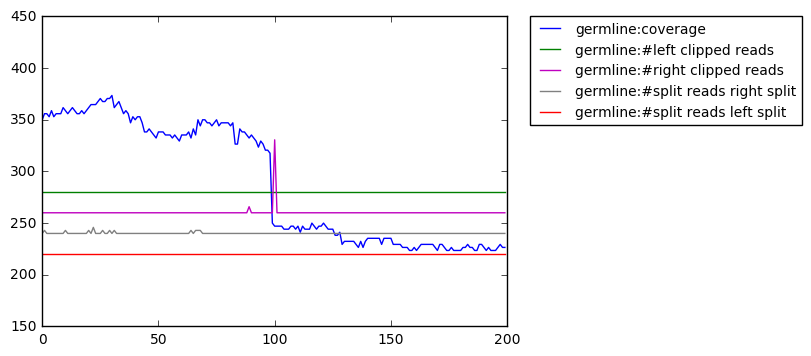

id: 1
Label: DEL_end


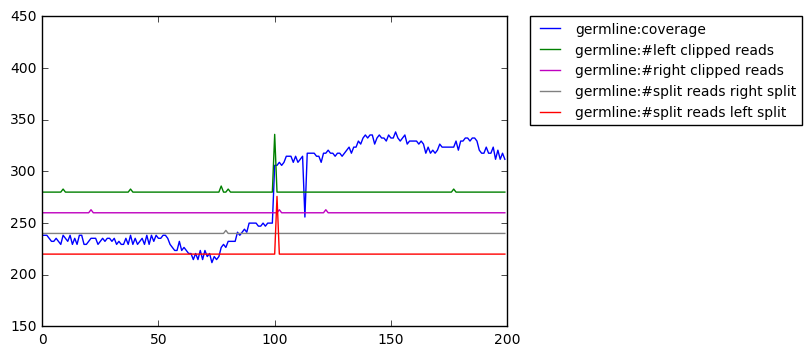

id: 2
Label: DEL_start


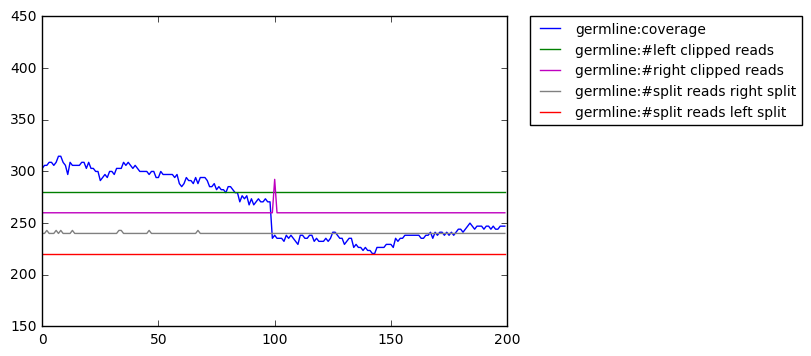

id: 3
Label: DEL_end


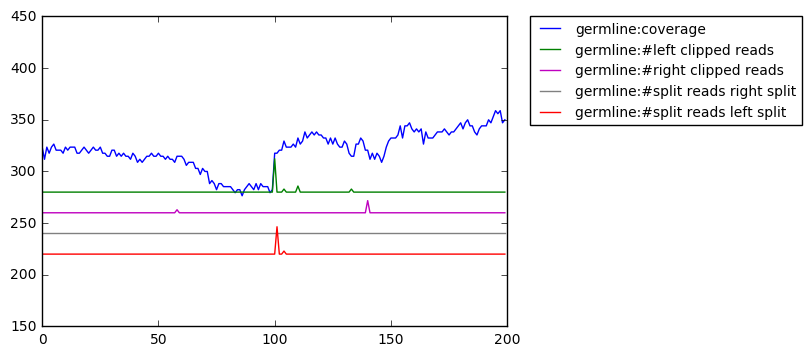

id: 4
Label: DEL_end


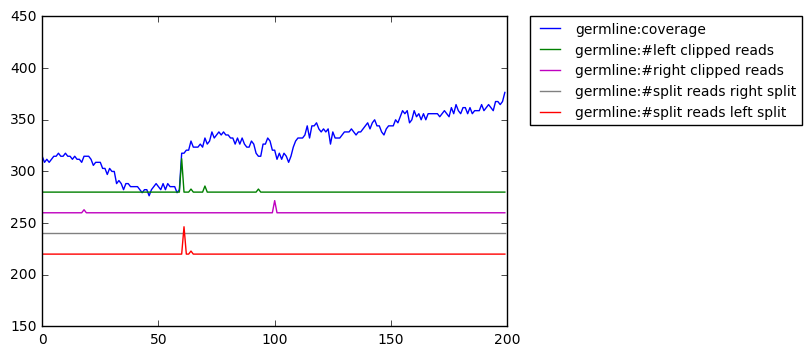

id: 5
Label: DEL_start


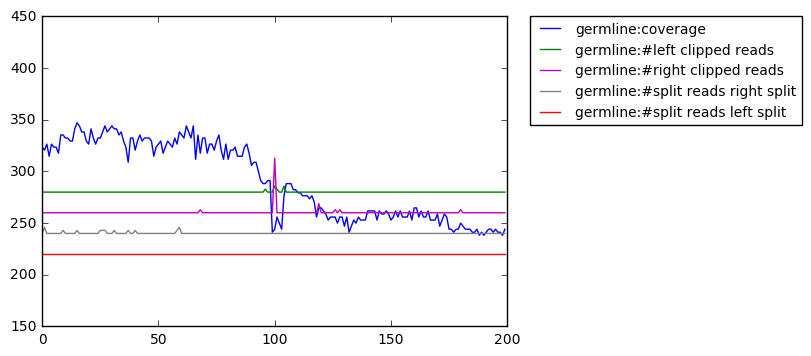

id: 6
Label: DEL_start


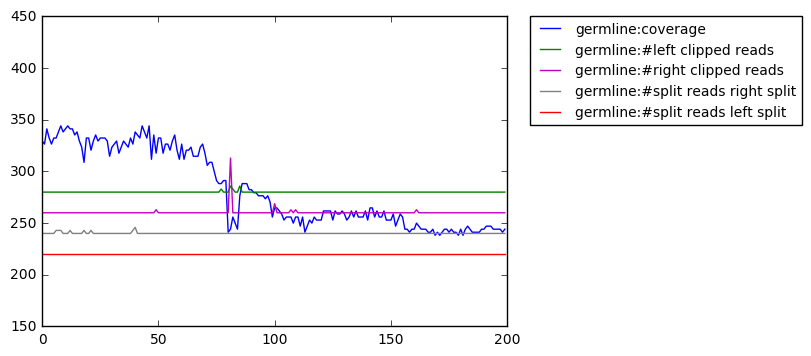

id: 7
Label: DEL_end


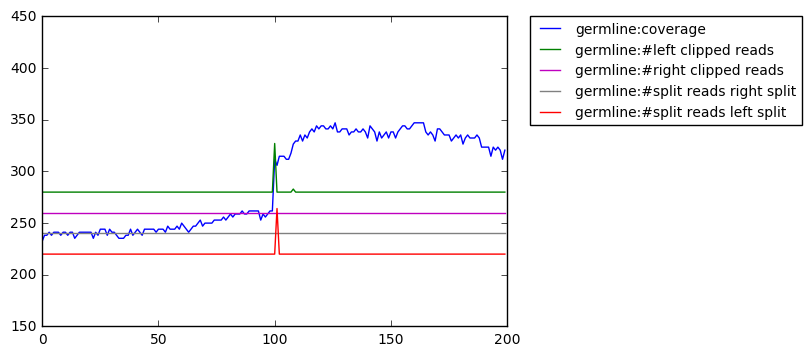

id: 8
Label: DEL_start


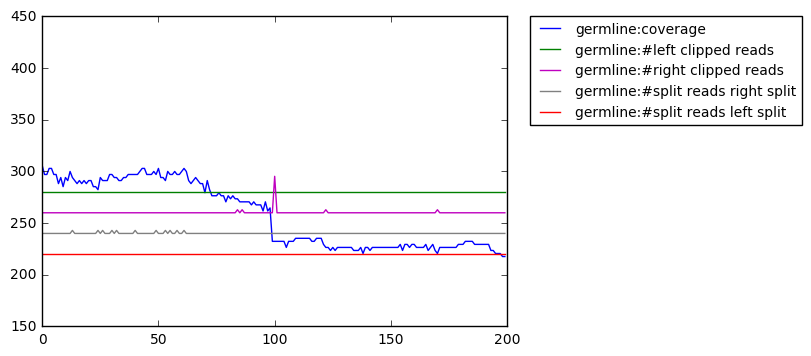

id: 9
Label: DEL_end


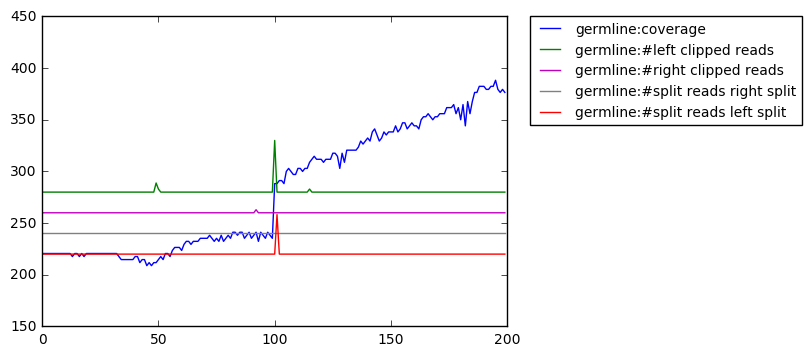

id: 10
Label: DEL_start


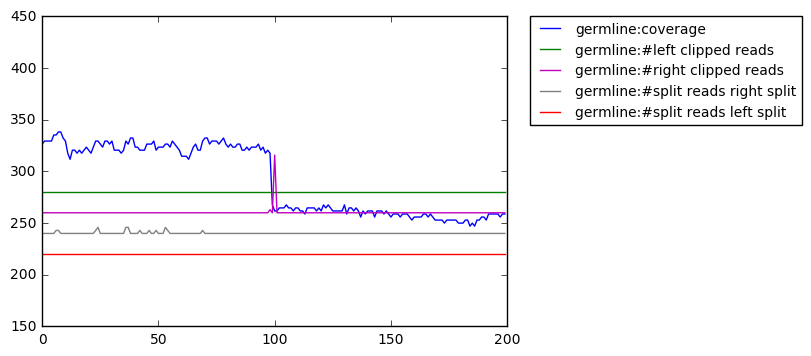

id: 11
Label: DEL_start


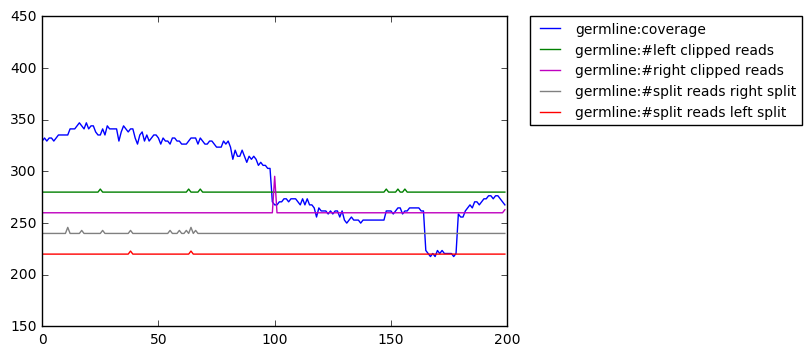

id: 12
Label: DEL_end


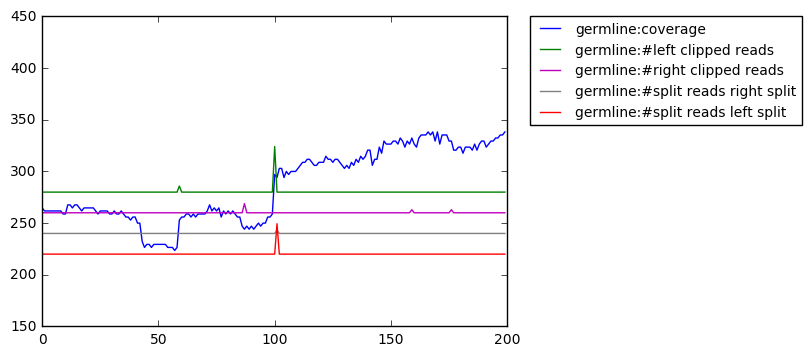

id: 13
Label: DEL_start


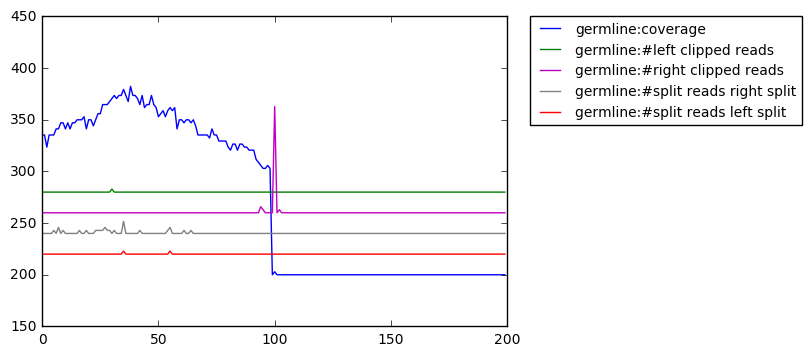

id: 14
Label: DEL_end


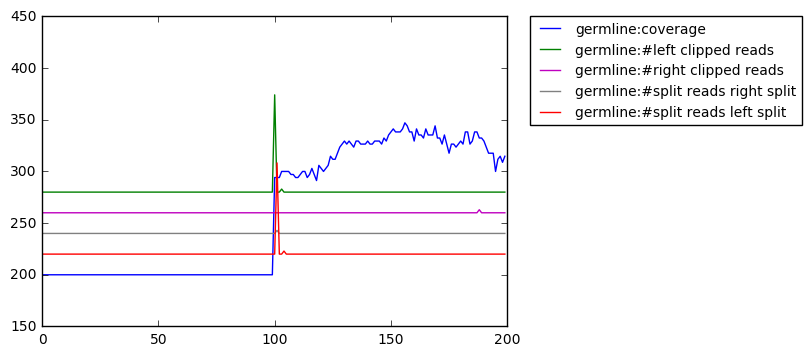

id: 15
Label: DEL_start


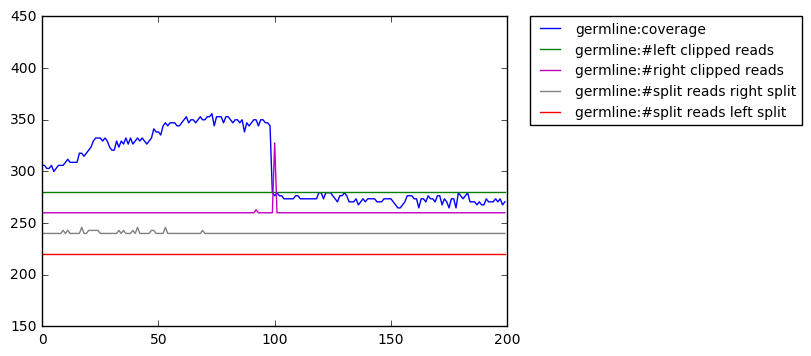

id: 16
Label: DEL_start


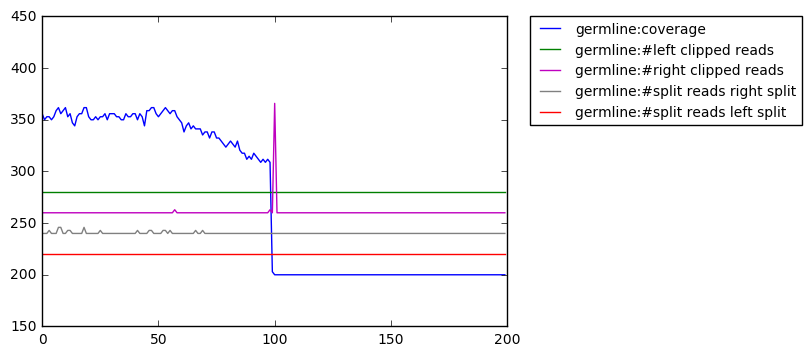

id: 17
Label: DEL_end


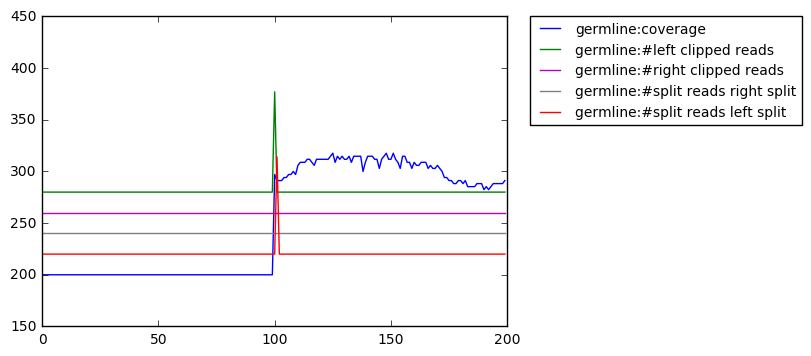

id: 18
Label: DEL_start


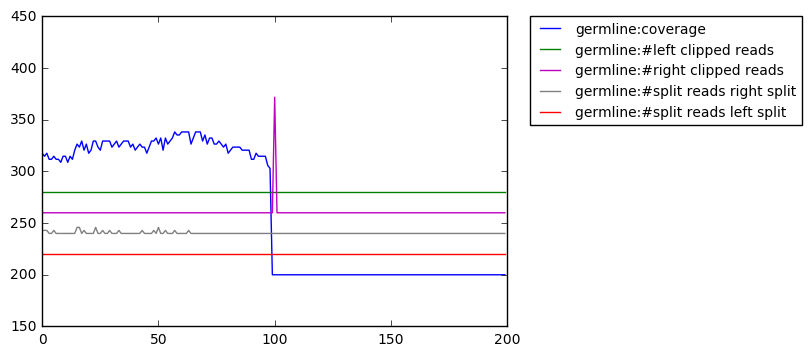

id: 19
Label: DEL_end


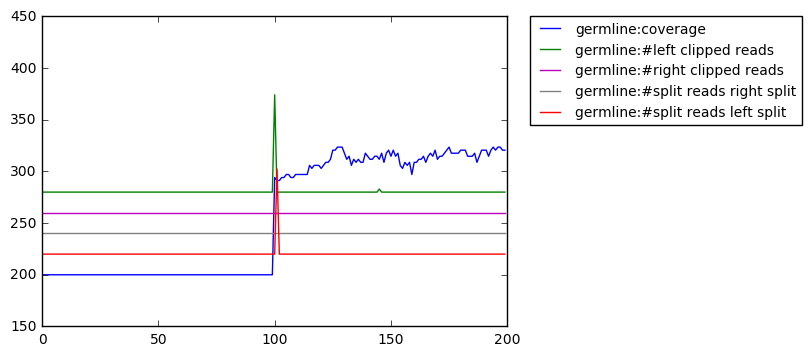

id: 20
Label: DEL_start


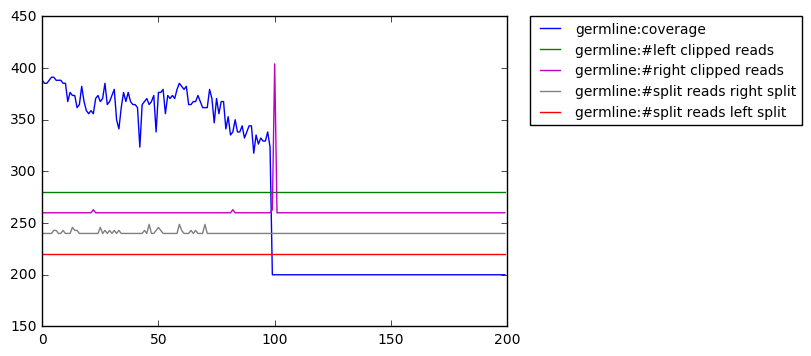

id: 21
Label: DEL_start


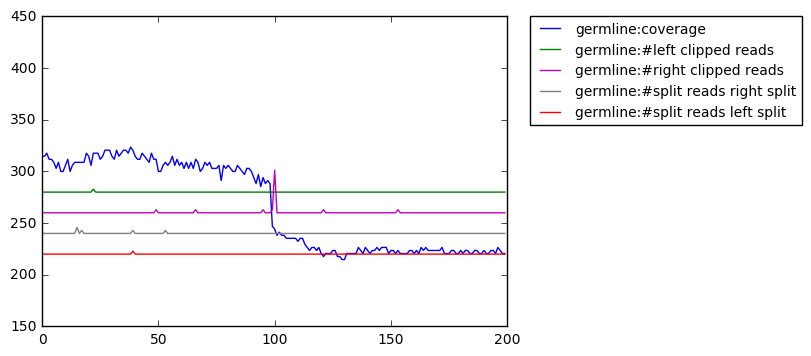

id: 22
Label: DEL_end


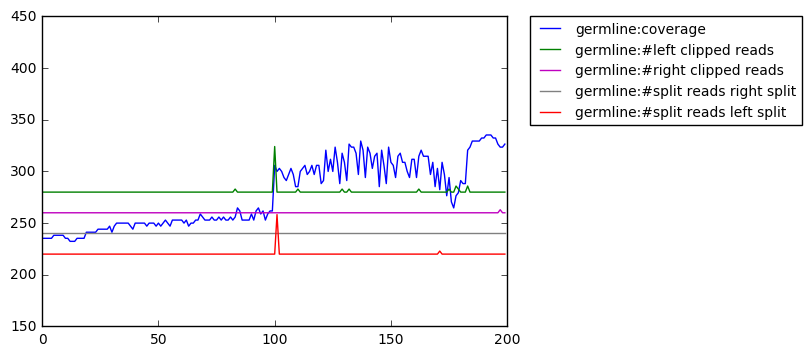

id: 23
Label: DEL_start


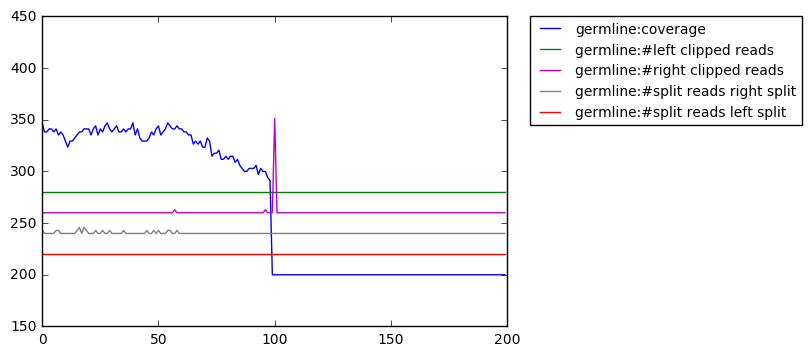

id: 24
Label: DEL_end


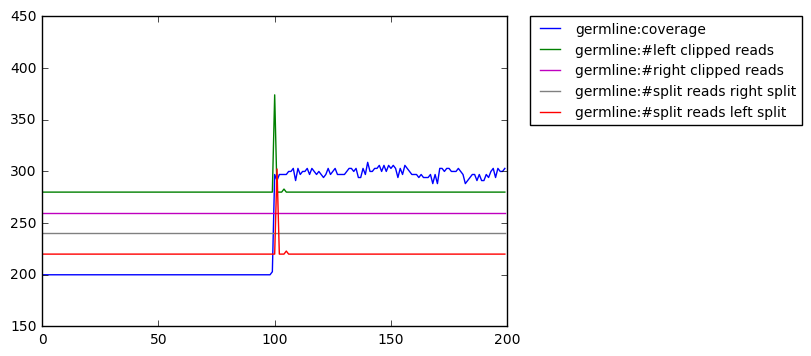

id: 25
Label: DEL_start


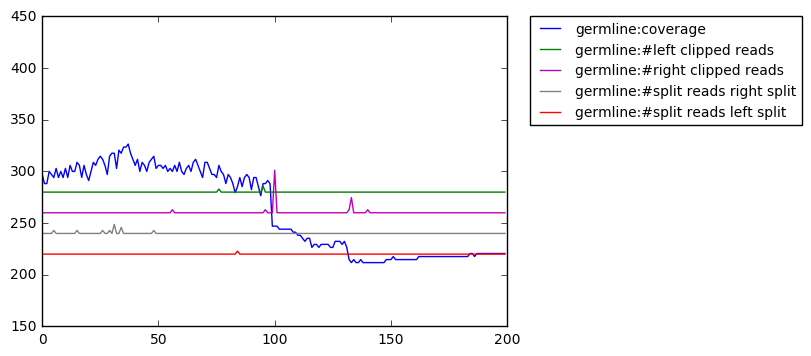

id: 26
Label: DEL_end


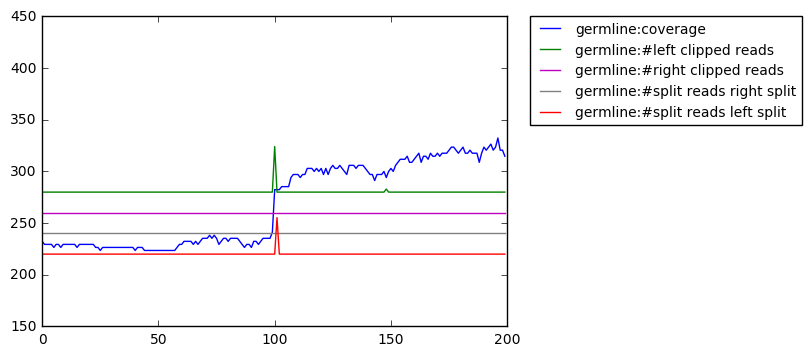

id: 27
Label: DEL_start


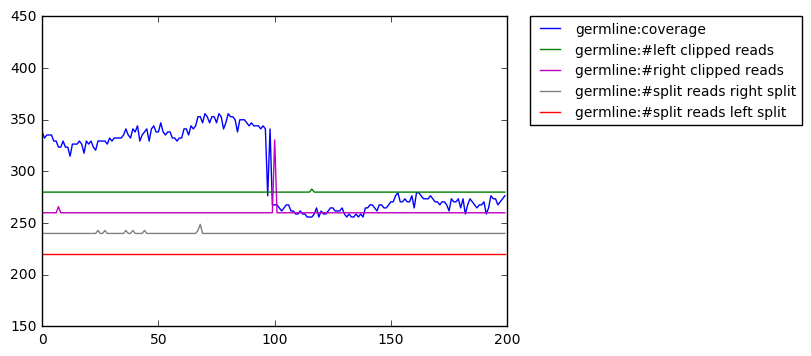

id: 28
Label: DEL_start


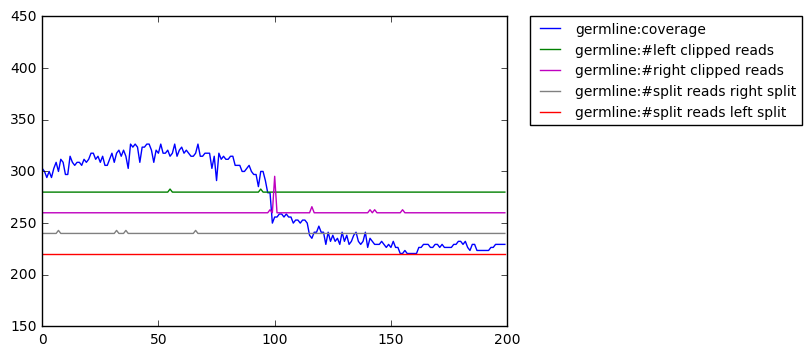

id: 29
Label: DEL_start


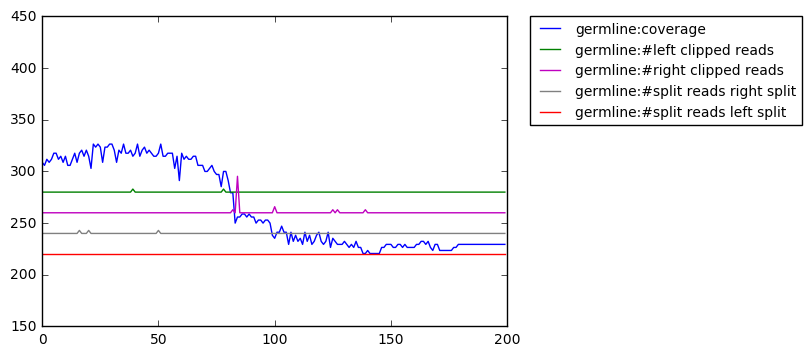

id: 30
Label: DEL_end


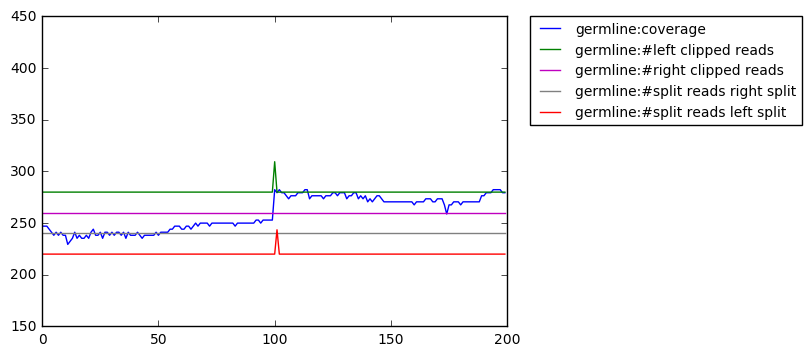

id: 31
Label: DEL_start


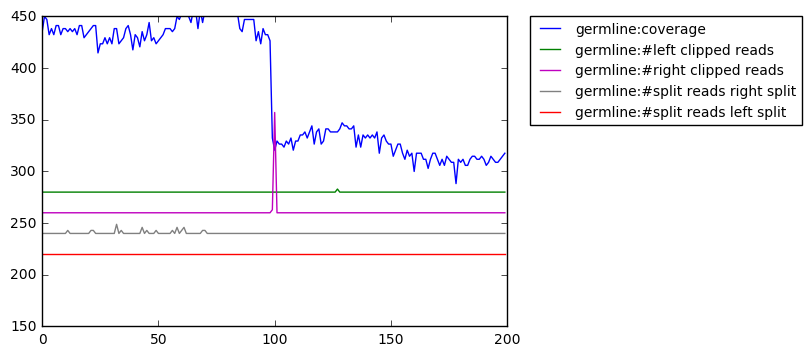

id: 32
Label: DEL_end


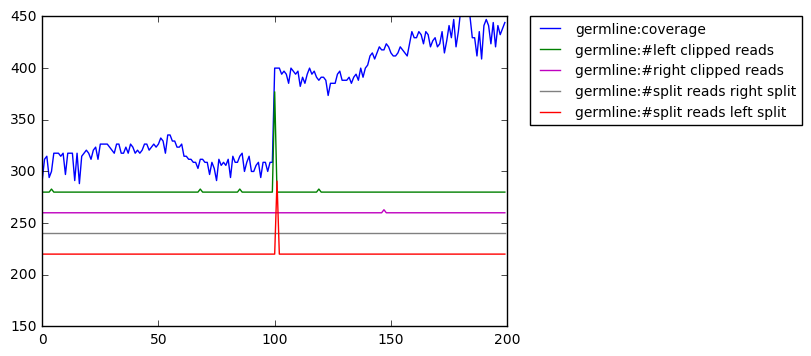

id: 33
Label: DEL_start


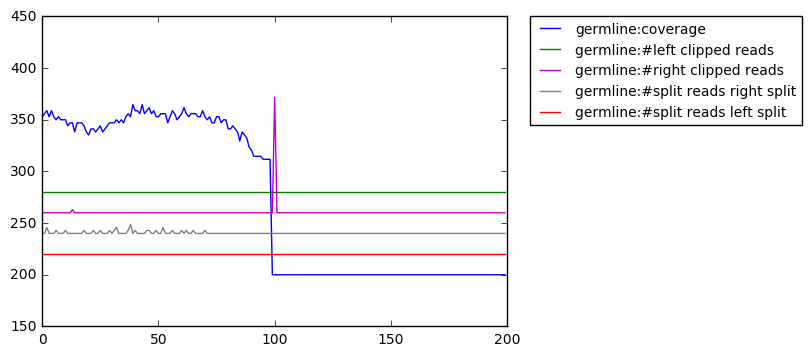

id: 34
Label: DEL_end


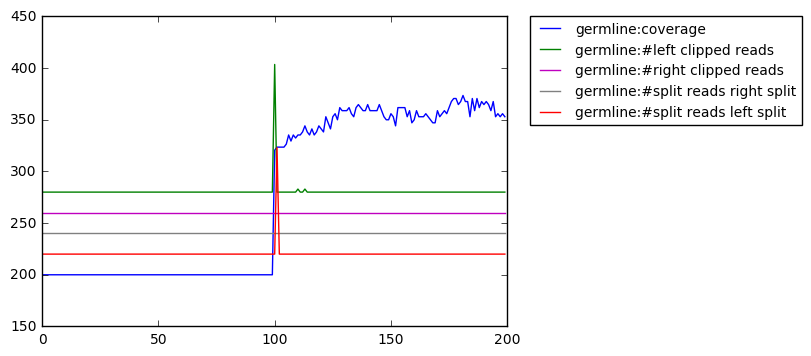

id: 35
Label: DEL_end


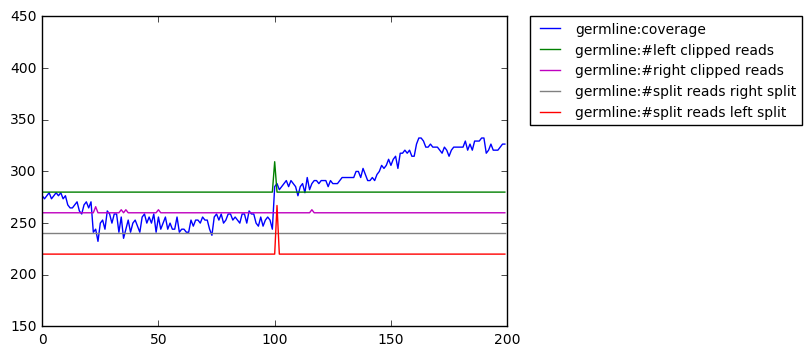

id: 36
Label: DEL_start


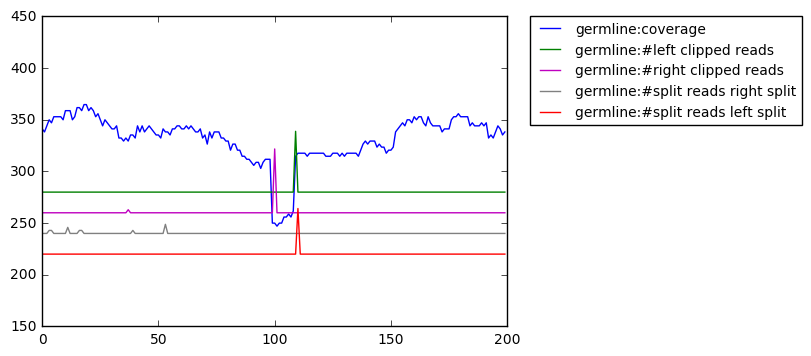

id: 37
Label: DEL_start


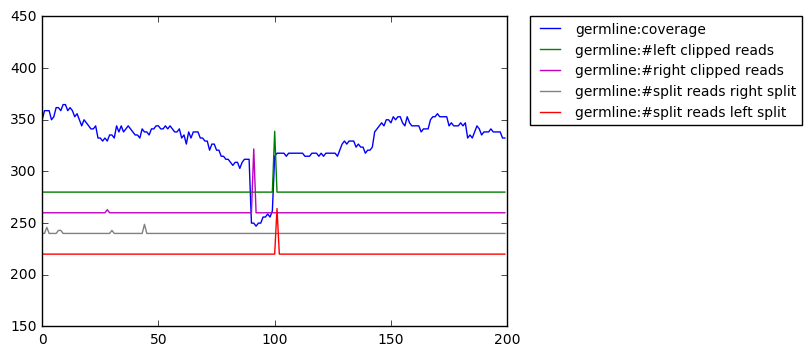

id: 38
Label: DEL_end


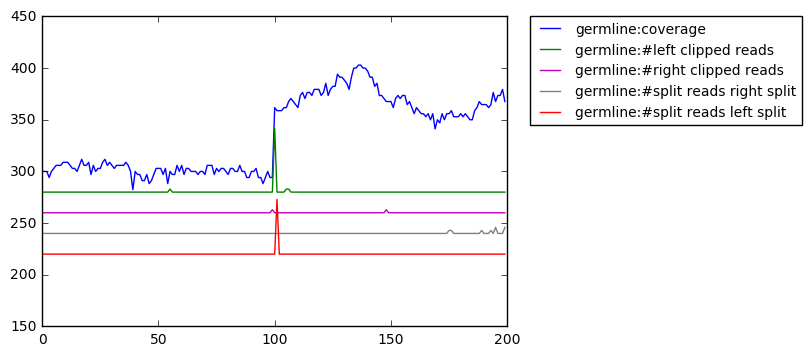

id: 39
Label: DEL_start


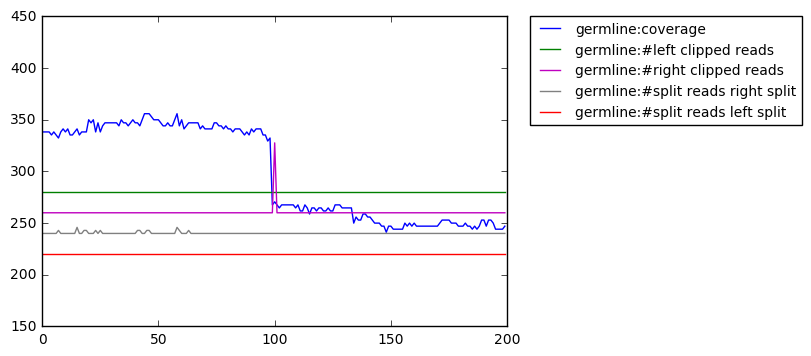

id: 40
Label: DEL_start


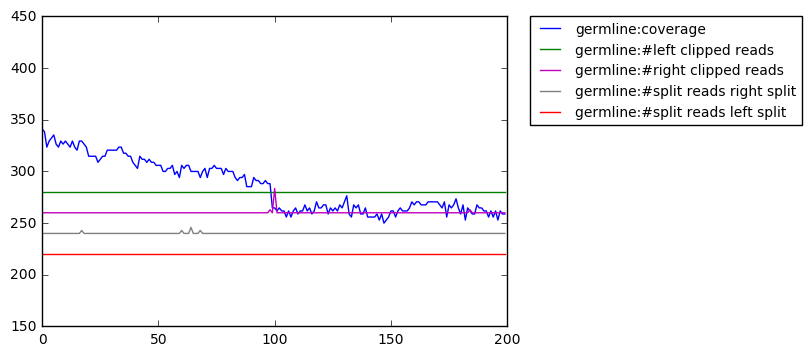

id: 41
Label: DEL_start


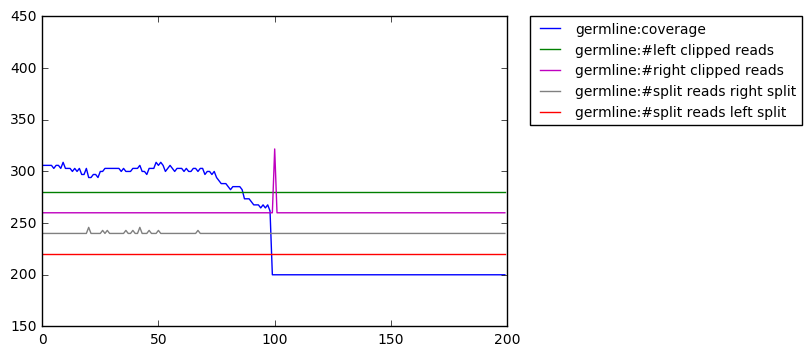

id: 42
Label: DEL_end


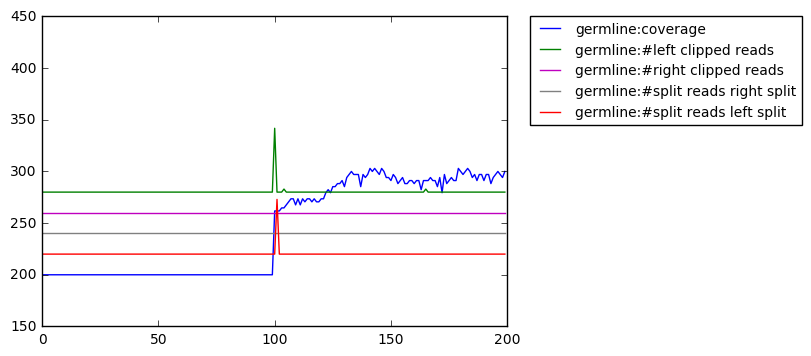

id: 43
Label: DEL_end


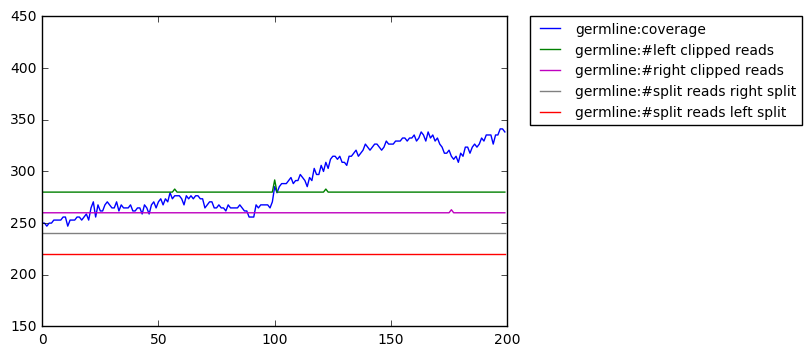

id: 44
Label: DEL_start


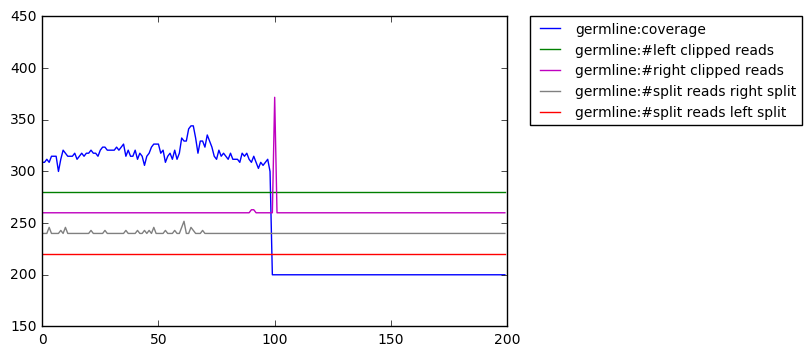

id: 45
Label: DEL_end


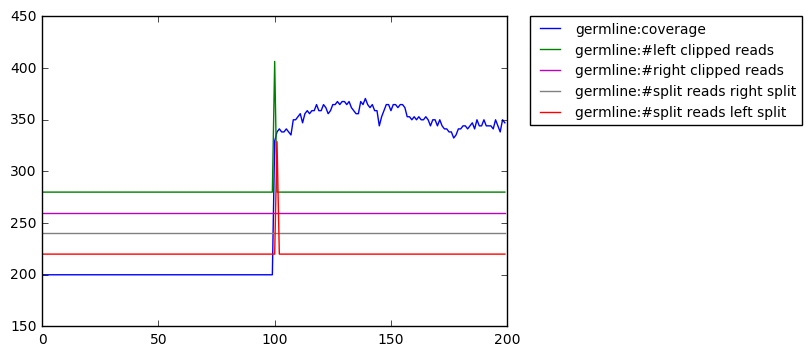

id: 46
Label: DEL_start


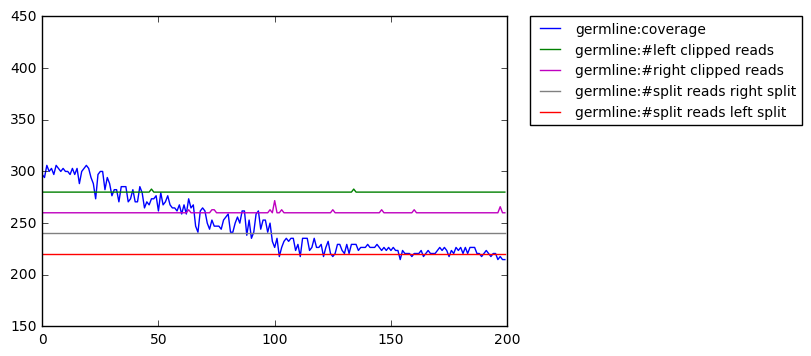

id: 47
Label: DEL_end


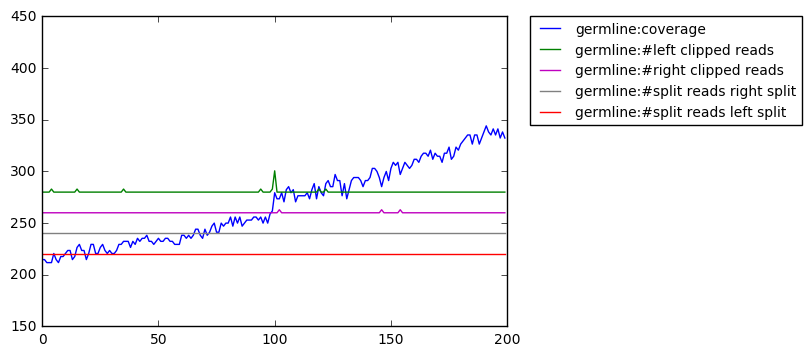

id: 48
Label: DEL_start


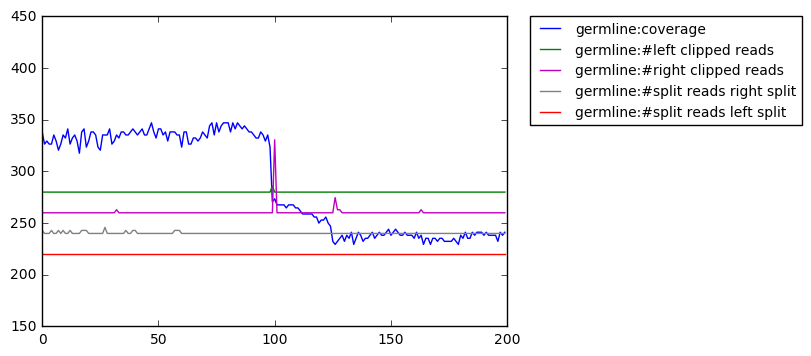

id: 49
Label: DEL_start


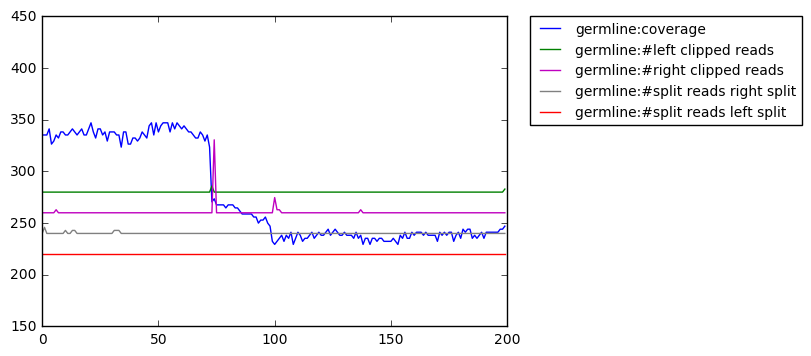

id: 50
Label: DEL_end


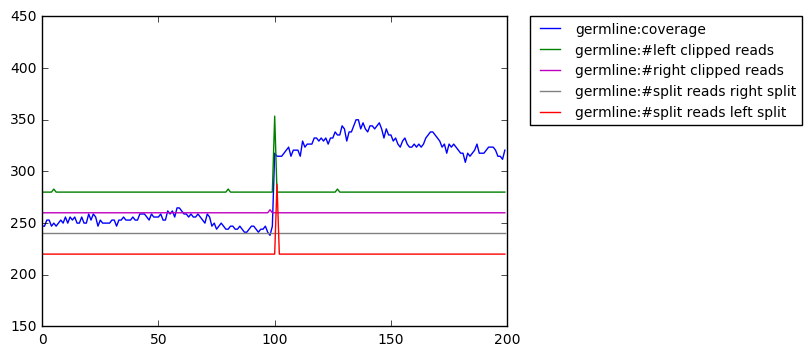

id: 51
Label: DEL_start


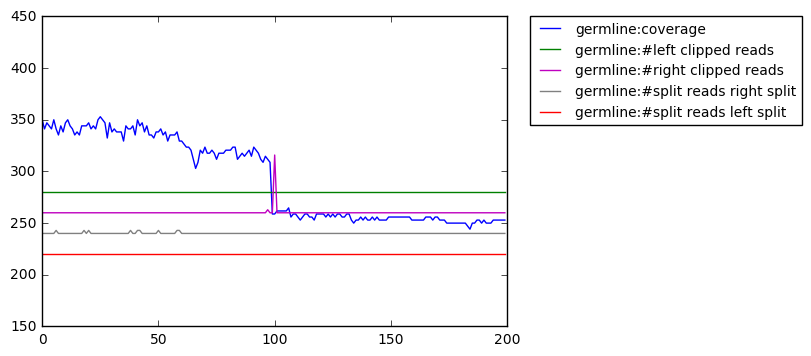

id: 52
Label: DEL_end


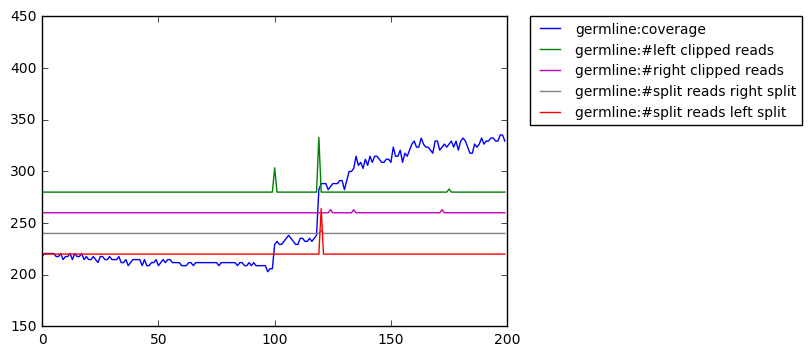

id: 53
Label: DEL_end


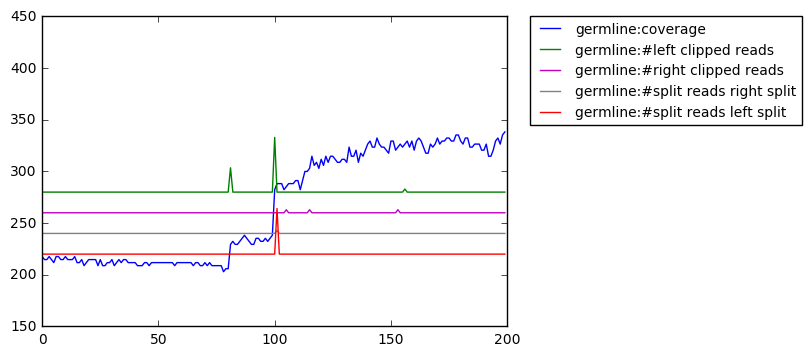

id: 54
Label: DEL_start


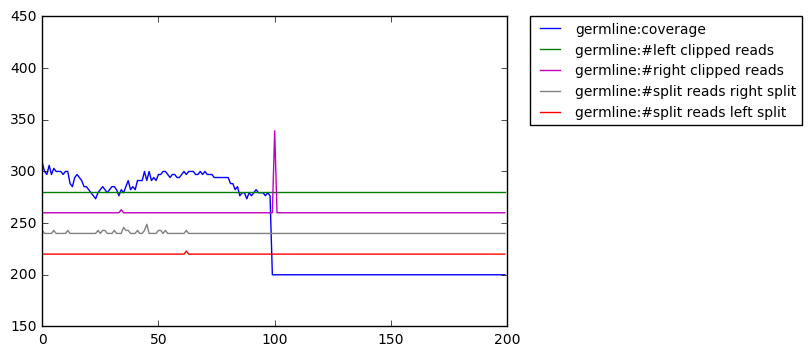

id: 55
Label: DEL_end


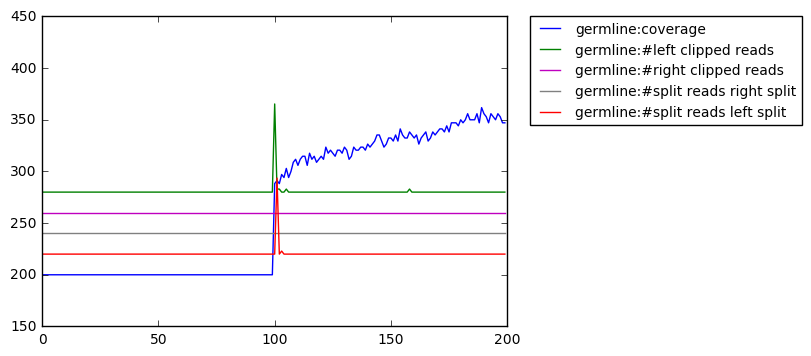

id: 56
Label: DEL_start


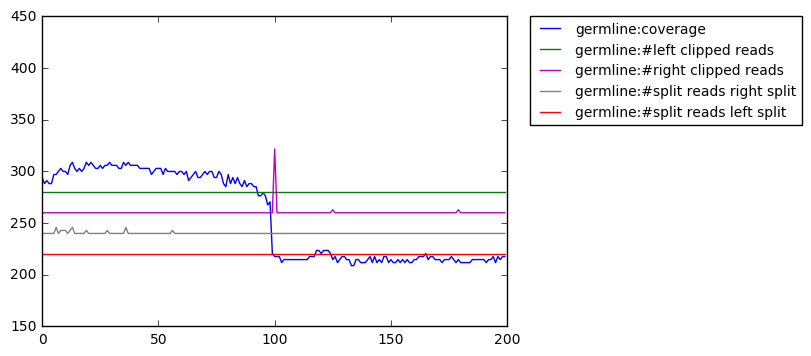

In [39]:
start_window = 0
n_windows = 57
plot_channels(start_window, n_windows)

id: 500
Label: DEL_start


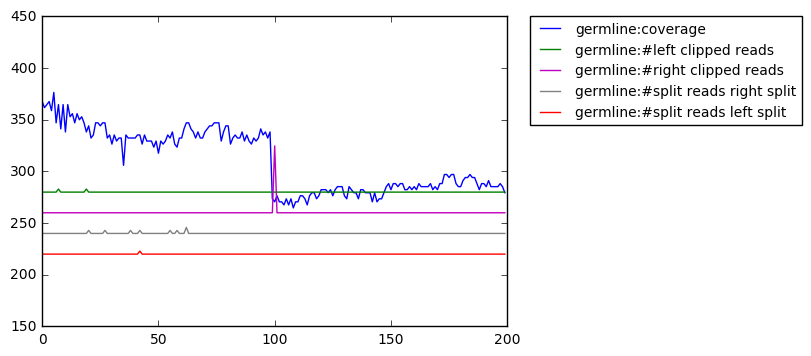

id: 501
Label: DEL_start


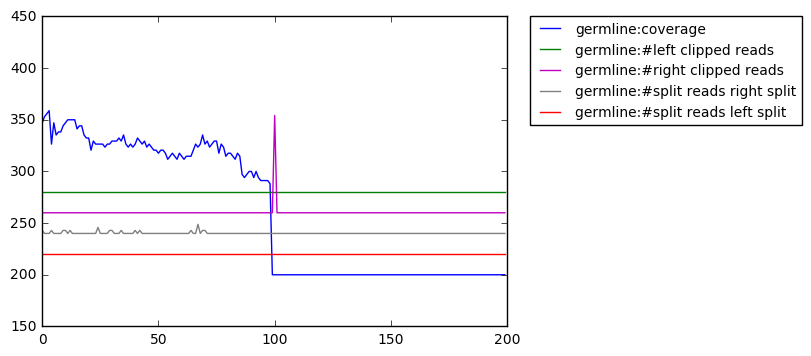

id: 502
Label: DEL_end


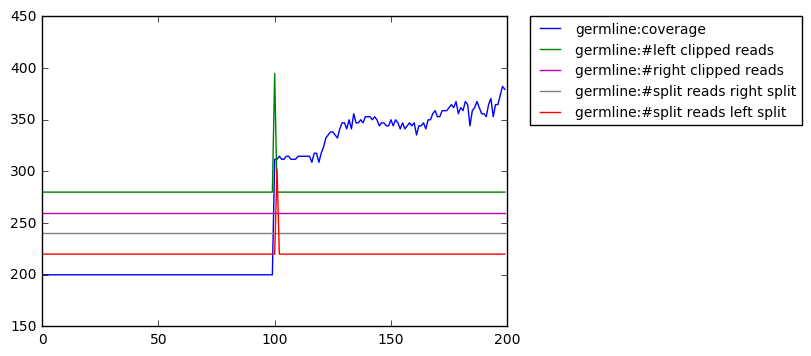

id: 503
Label: DEL_start


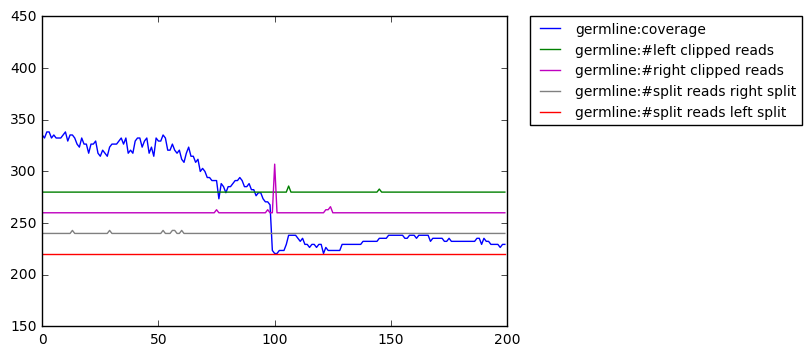

id: 504
Label: DEL_end


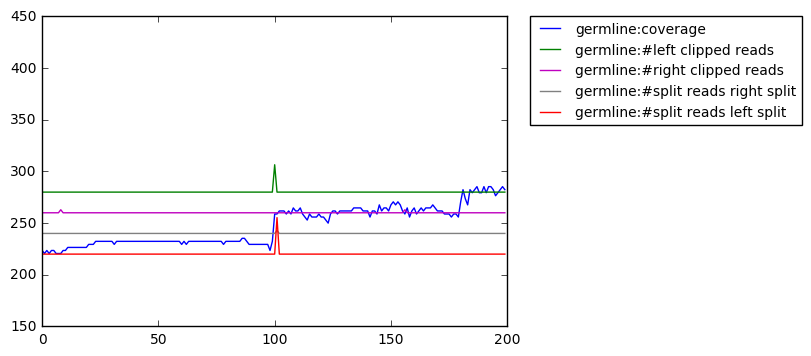

id: 505
Label: DEL_start


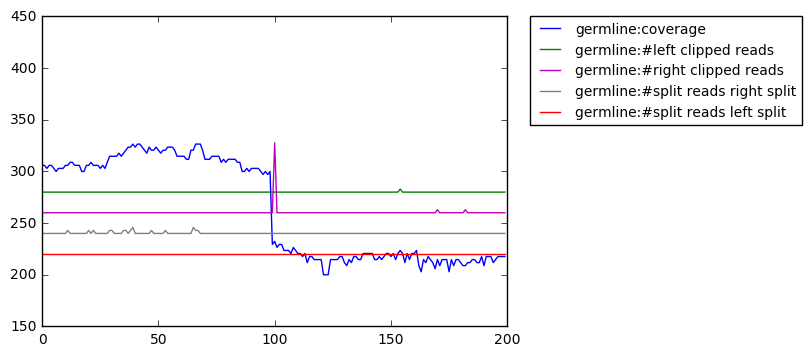

id: 506
Label: DEL_end


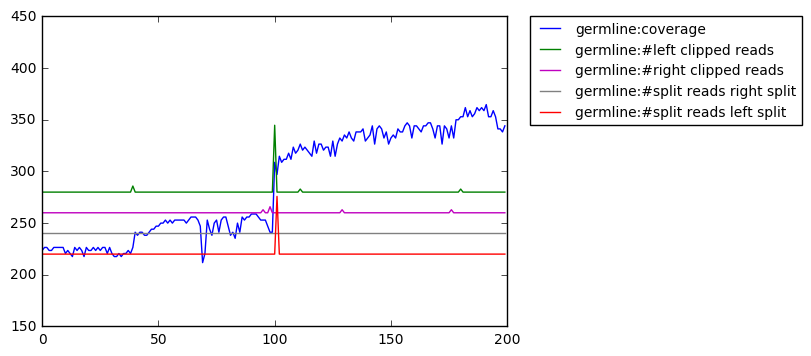

id: 507
Label: DEL_start


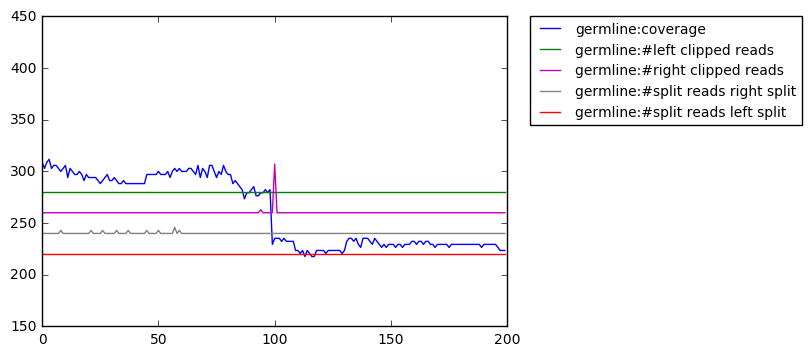

id: 508
Label: DEL_end


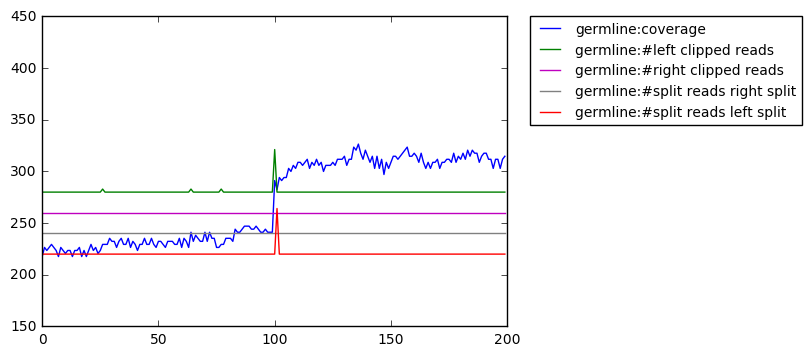

id: 509
Label: DEL_start


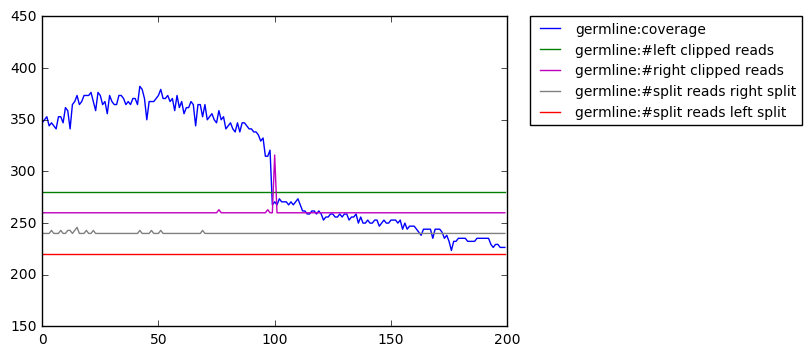

id: 510
Label: DEL_end


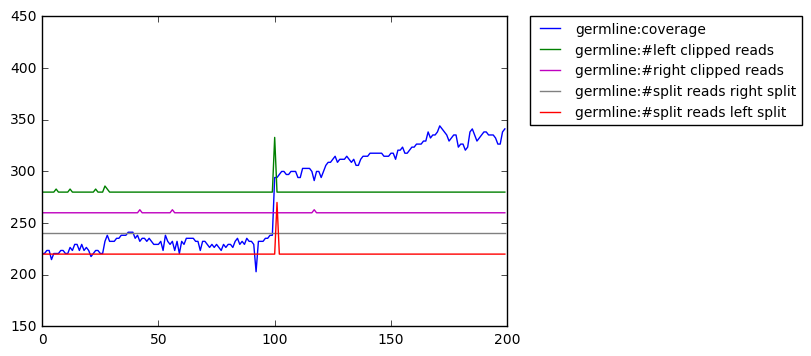

id: 511
Label: DEL_start


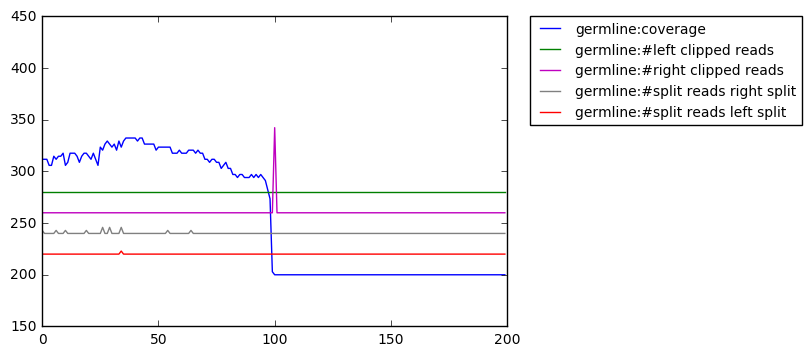

id: 512
Label: DEL_end


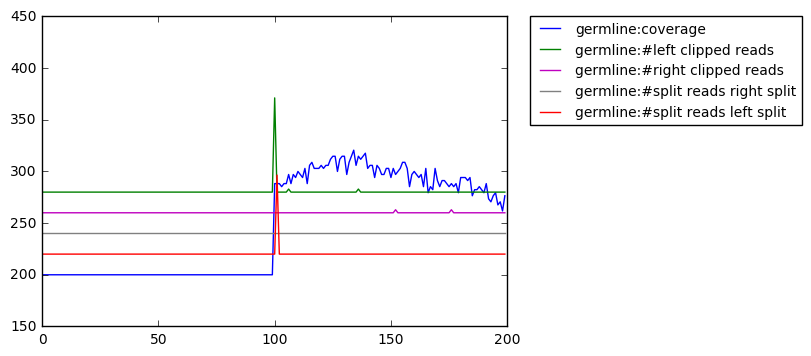

id: 513
Label: DEL_start


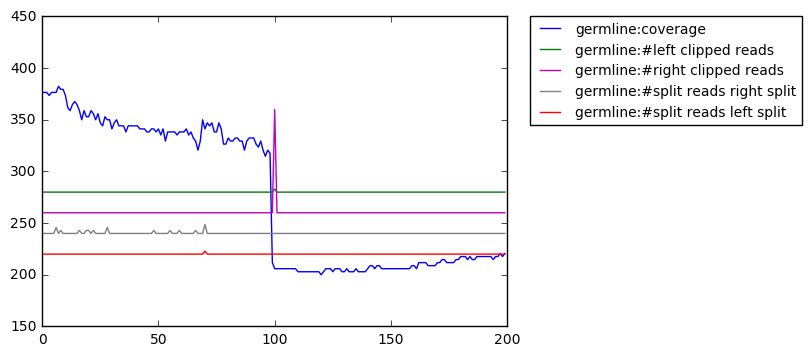

id: 514
Label: DEL_end


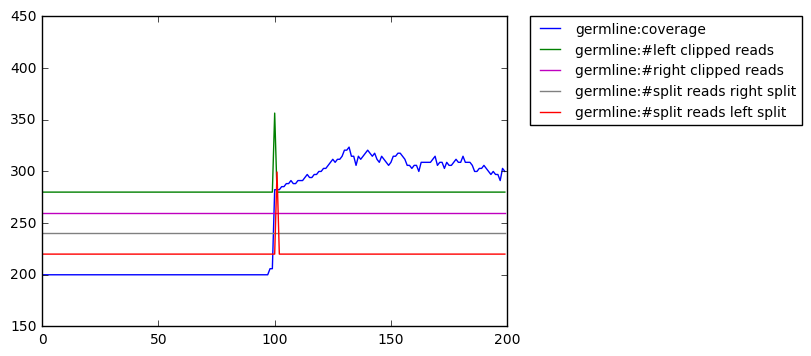

id: 515
Label: DEL_start


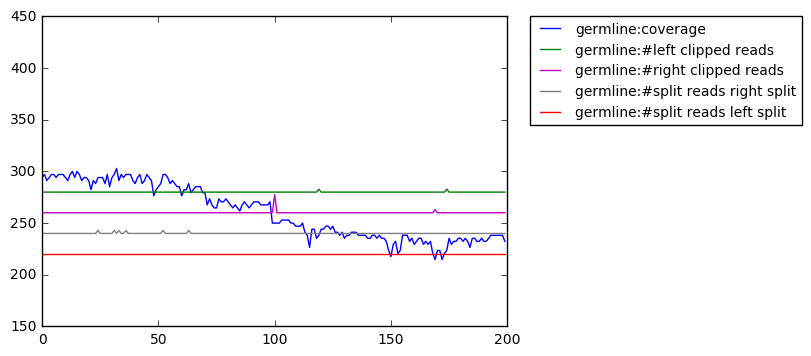

id: 516
Label: DEL_end


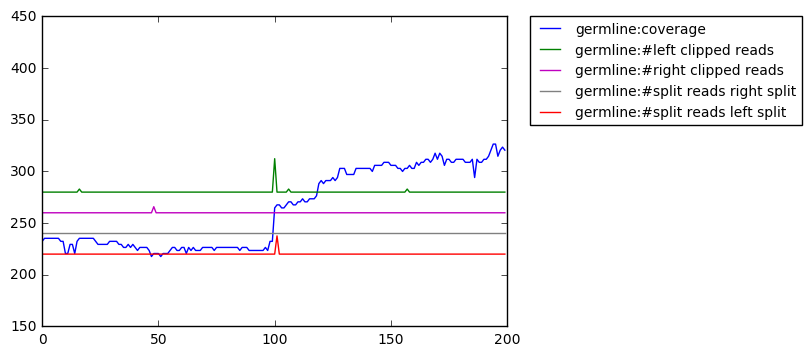

id: 517
Label: DEL_start


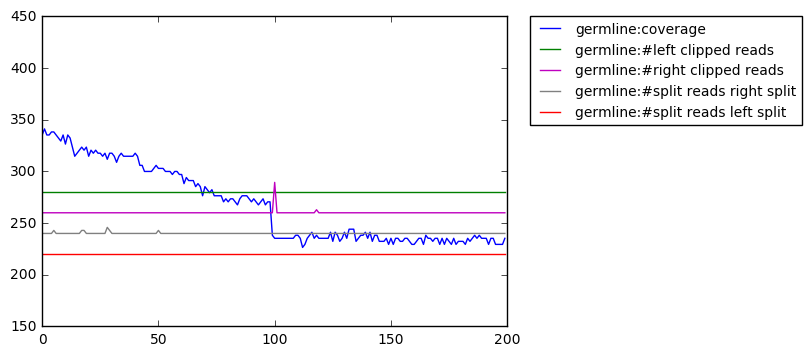

id: 518
Label: DEL_start


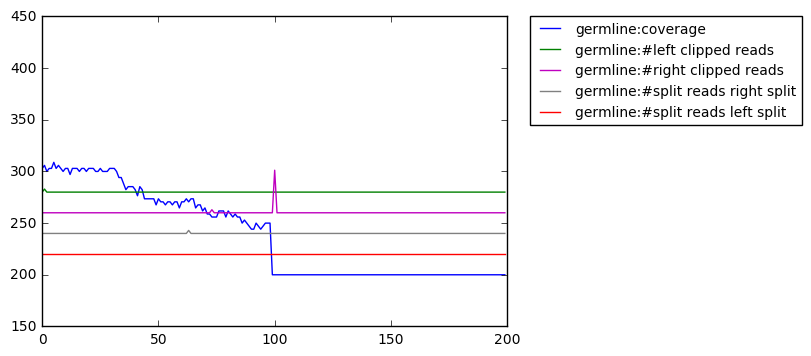

id: 519
Label: DEL_start


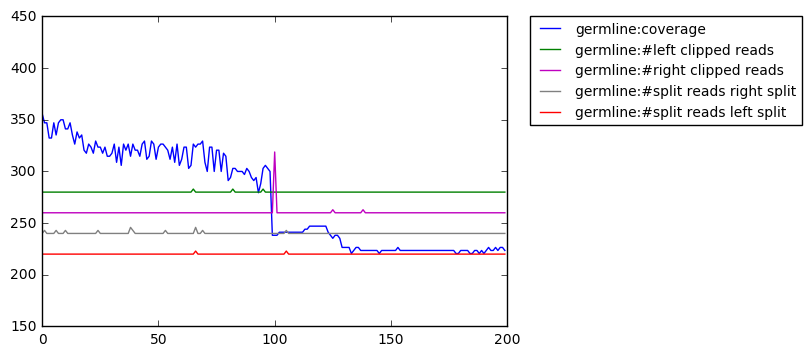

id: 520
Label: DEL_end


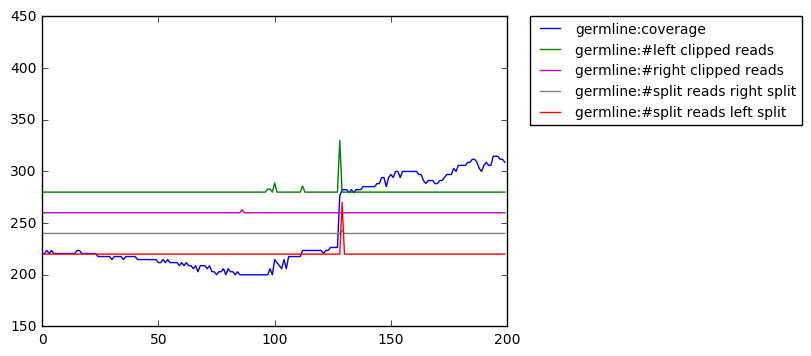

id: 521
Label: DEL_end


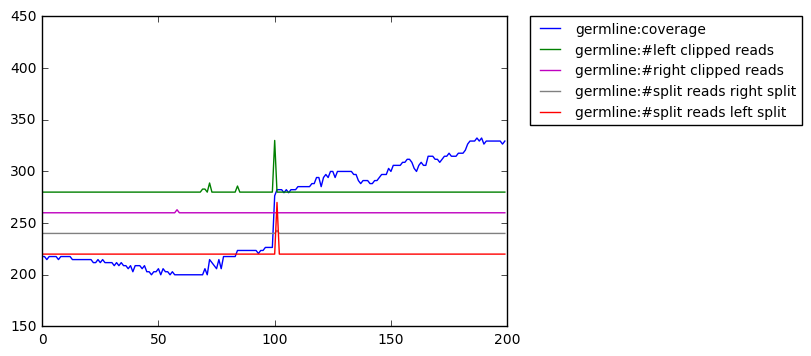

id: 522
Label: DEL_start


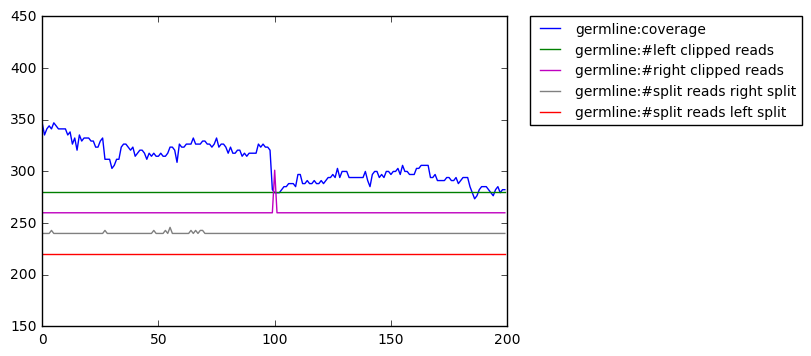

id: 523
Label: DEL_end


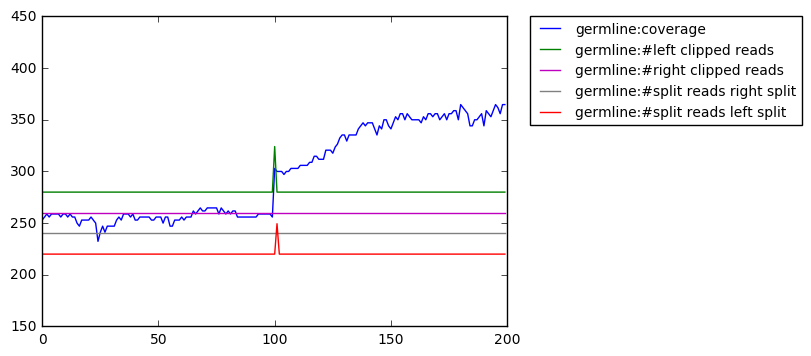

id: 524
Label: DEL_start


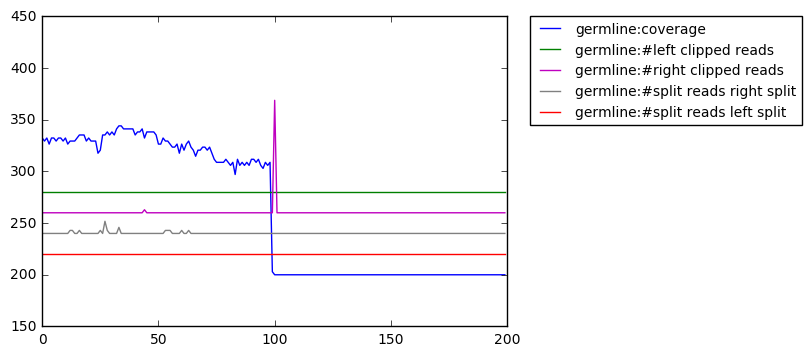

id: 525
Label: DEL_end


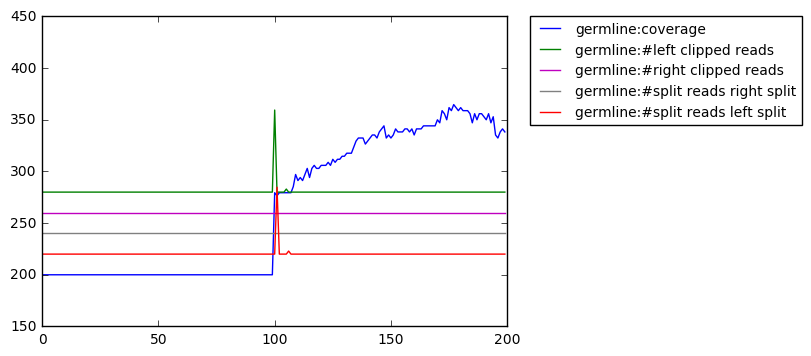

id: 526
Label: DEL_start


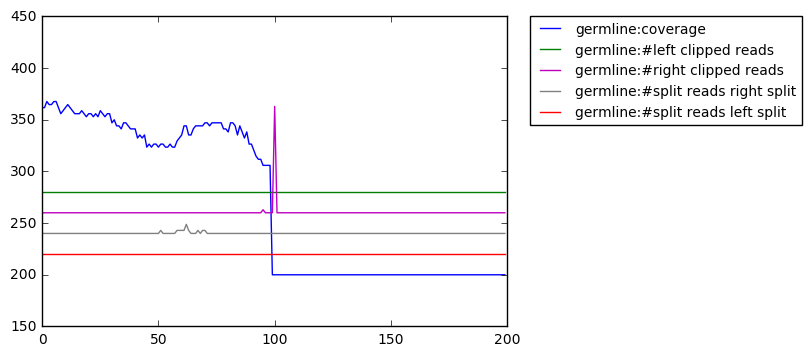

id: 527
Label: DEL_end


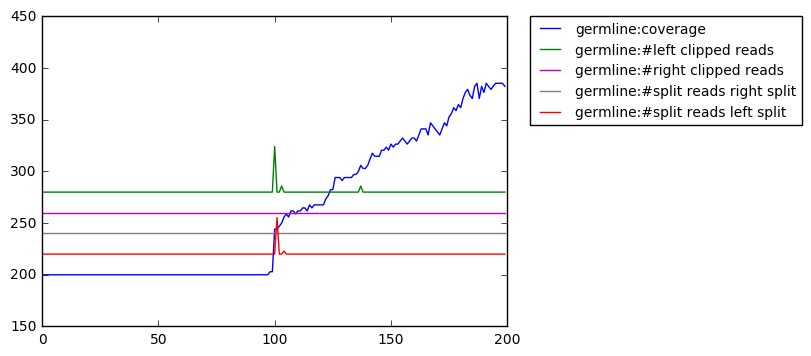

id: 528
Label: DEL_start


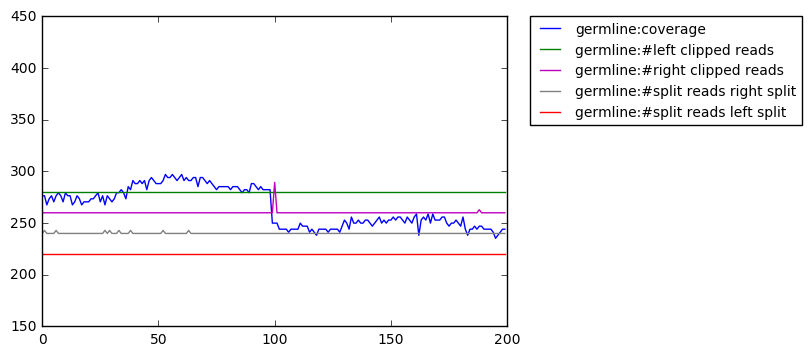

id: 529
Label: DEL_end


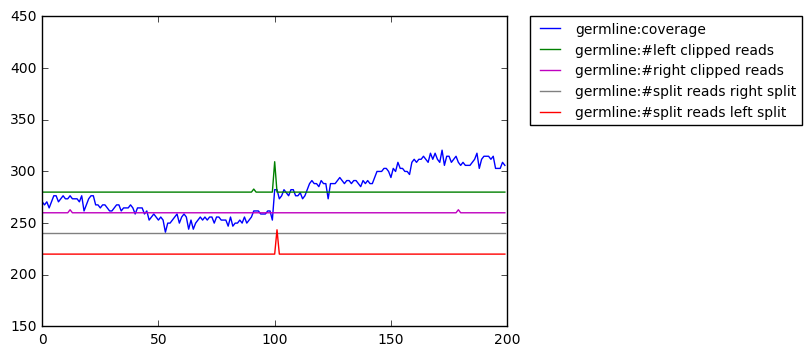

id: 530
Label: DEL_start


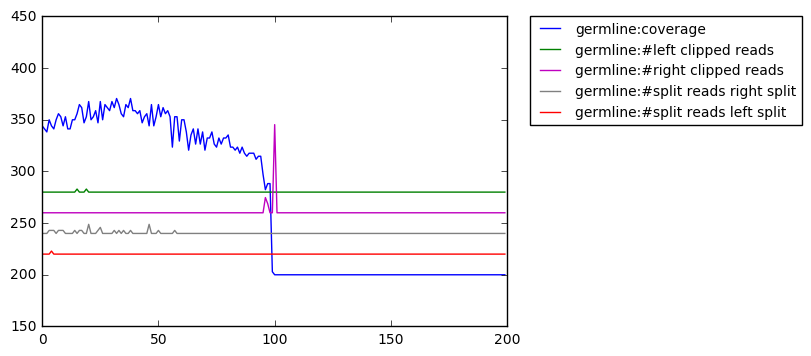

id: 531
Label: DEL_start


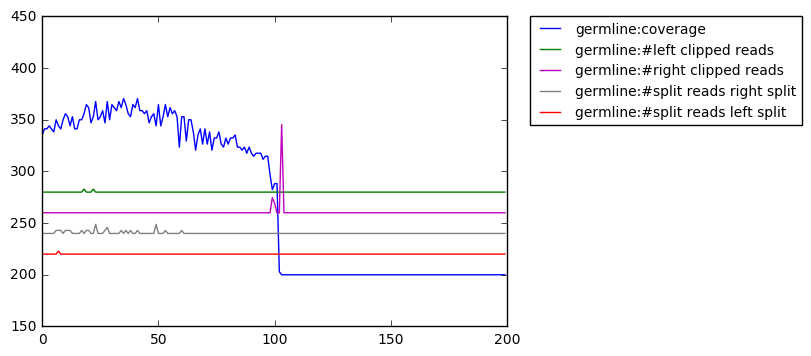

id: 532
Label: DEL_start


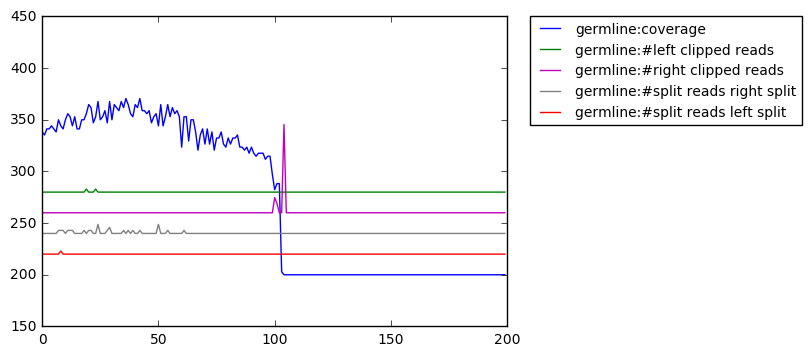

id: 533
Label: DEL_start


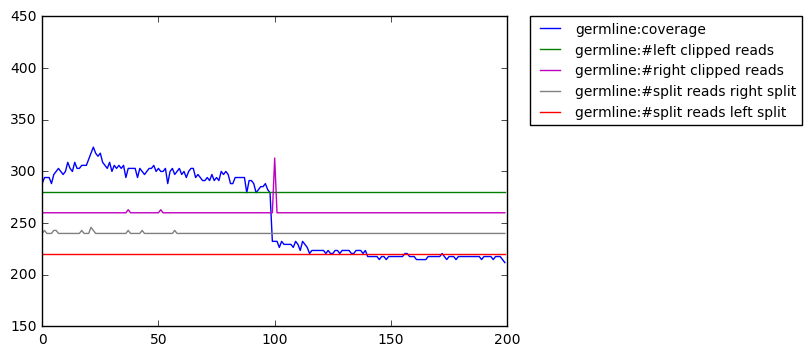

id: 534
Label: DEL_end


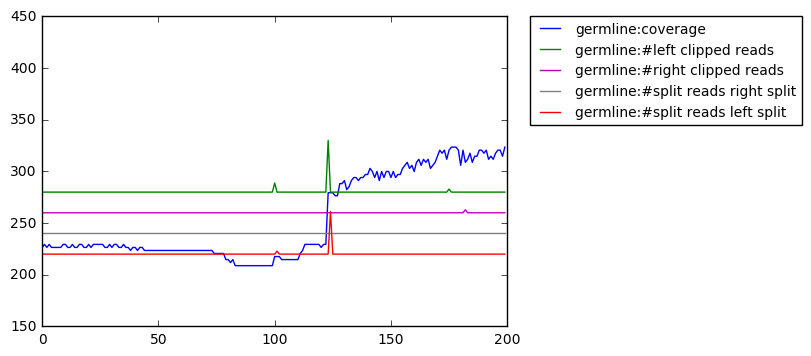

id: 535
Label: DEL_start


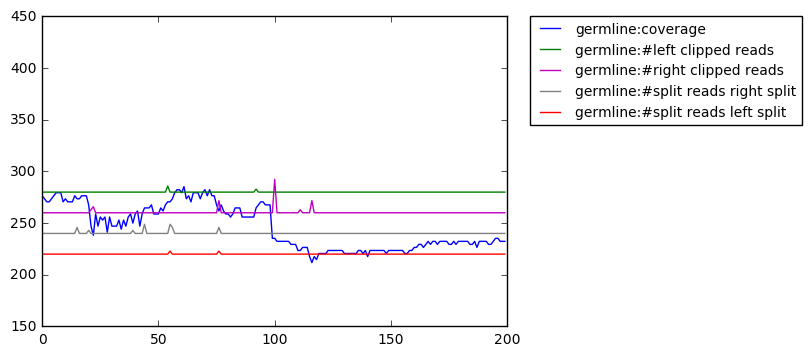

id: 536
Label: DEL_start


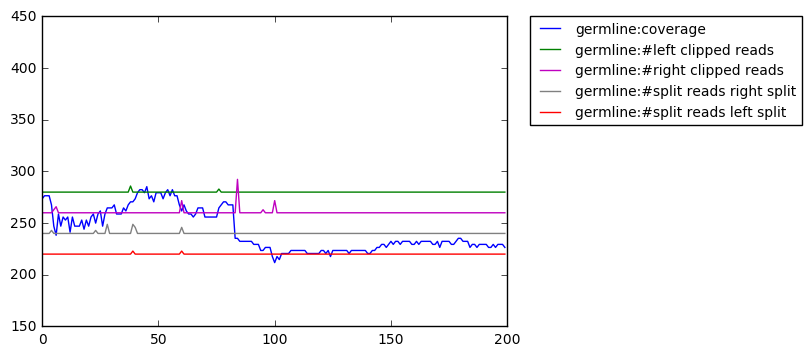

id: 537
Label: DEL_start


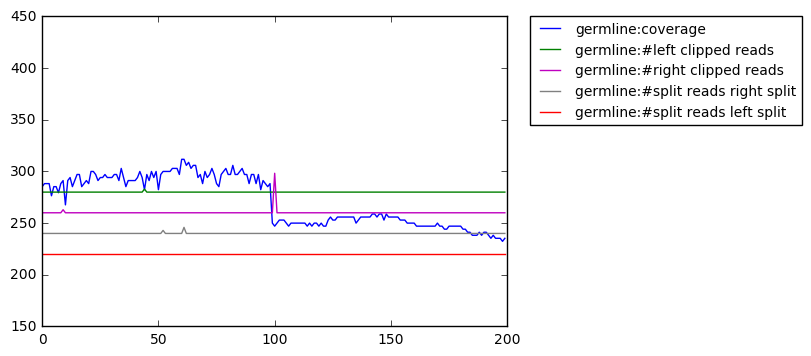

id: 538
Label: DEL_end


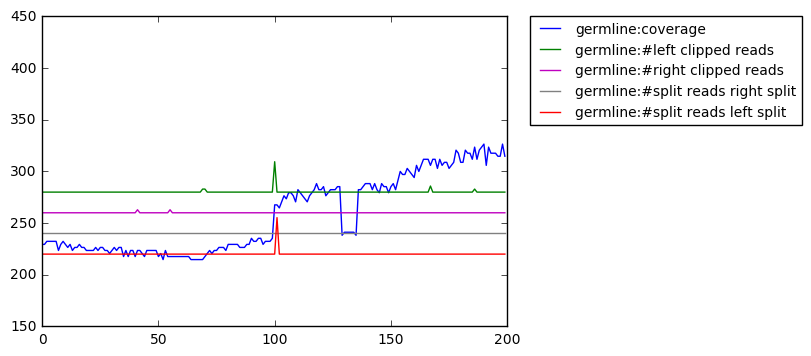

id: 539
Label: DEL_start


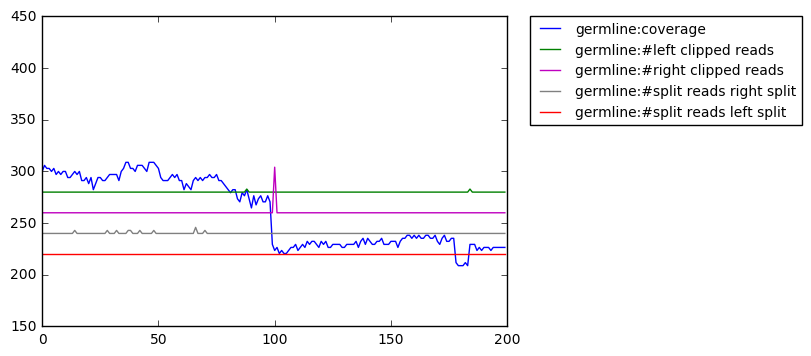

id: 540
Label: DEL_end


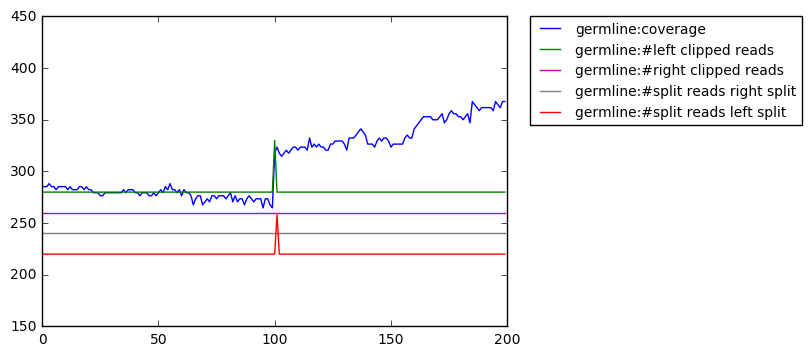

id: 541
Label: DEL_start


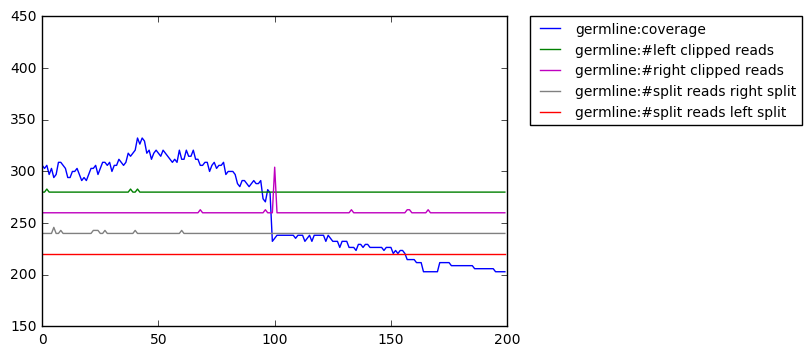

id: 542
Label: DEL_end


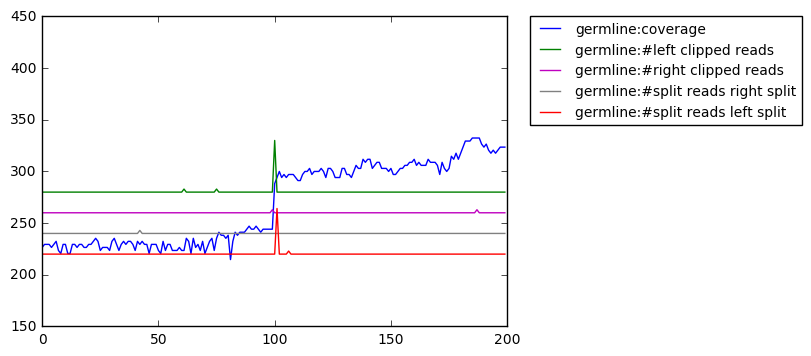

id: 543
Label: DEL_start


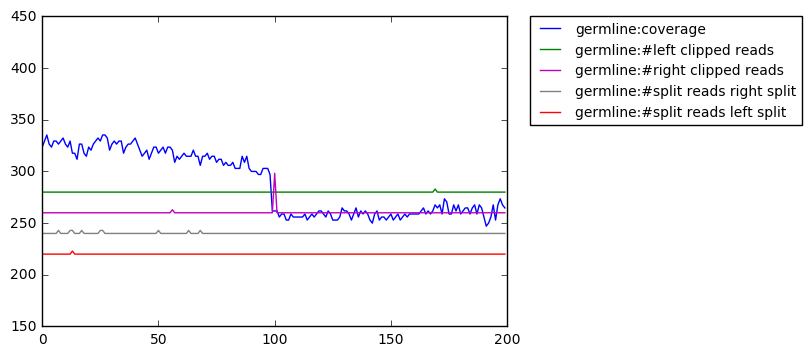

id: 544
Label: DEL_end


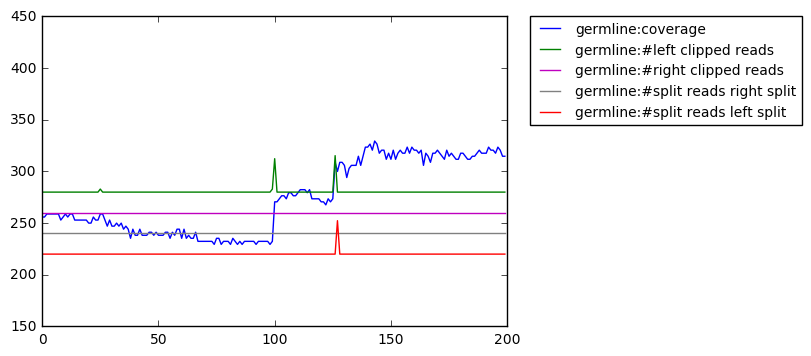

id: 545
Label: DEL_end


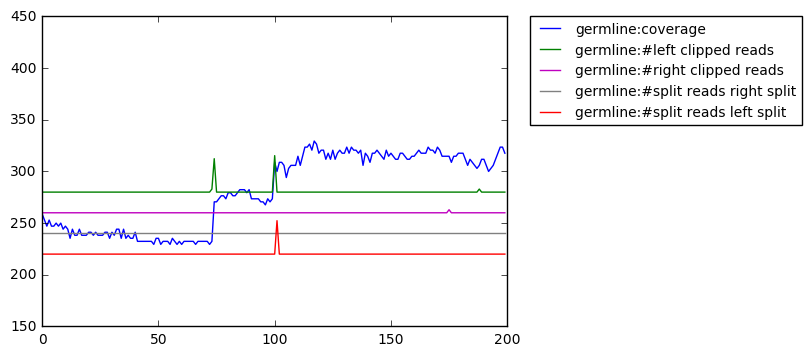

id: 546
Label: DEL_start


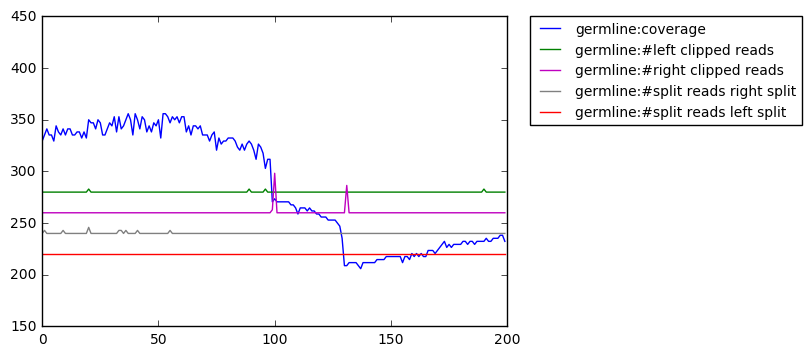

id: 547
Label: DEL_end


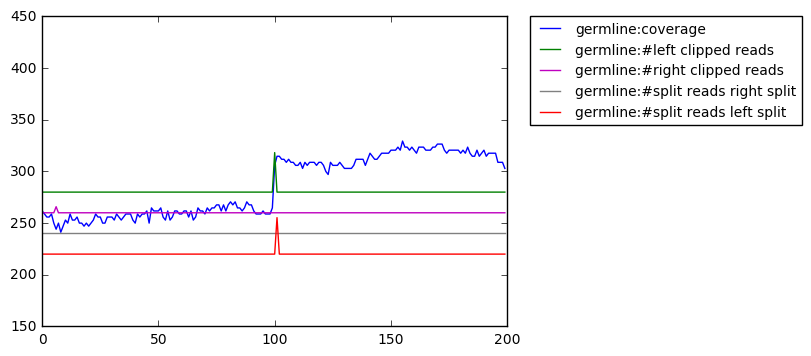

id: 548
Label: DEL_start


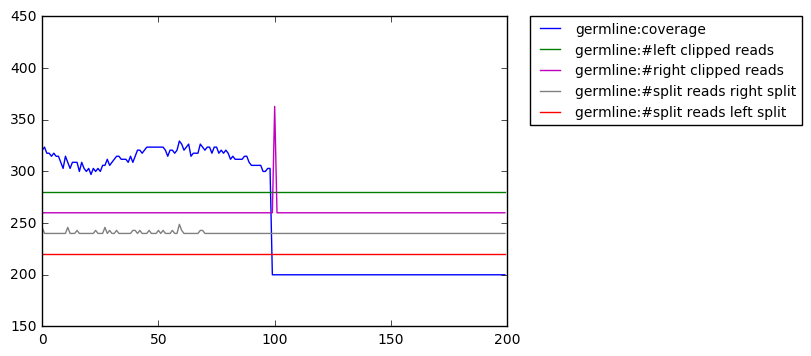

id: 549
Label: DEL_end


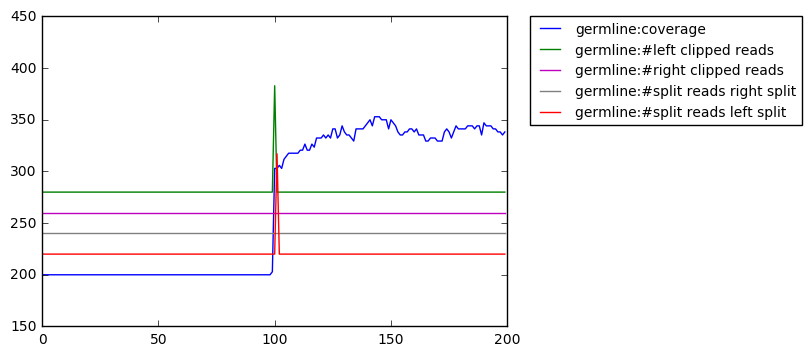

In [40]:
n_windows = 50
start_window = 500
plot_channels(start_window, n_windows)

   
## Transposes every window in X, to comply to McFly format

In [41]:
def transposeDataset(X):
    image = []
    for i in range (0, len(X -1)):
        tr = X[i].transpose()
        image.append(tr)
    return np.array(image)

image1 = transposeDataset(X_train)
image2 = transposeDataset(X_val)
image3 = transposeDataset(X_test)
X_train = image1
X_val = image2
X_test = image3

n_channels = len(X_train[0][0])
print(len(X_test[0][0]))

5


## Prepare the labels in McFly format

In [42]:
mapclasses = {'DEL_start': 1, 'DEL_end': 0,  'noSV': 2}
print(mapclasses)

{'DEL_start': 1, 'noSV': 2, 'DEL_end': 0}


In [43]:
y_train = np.array([mapclasses[c] for c in y_train], dtype='int')
y_val = np.array([mapclasses[c] for c in y_val], dtype='int')
y_test = np.array([mapclasses[c] for c in y_test], dtype='int')
y_train_binary = to_categorical(y_train)
y_val_binary = to_categorical(y_val)
y_test_binary = to_categorical(y_test)

In [44]:
y_test_binary

array([[ 0.,  1.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       ..., 
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.]])

In [45]:
y_val_binary

array([[ 0.,  1.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       ..., 
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.]])

In [46]:
X_train.shape

(173533, 200, 5)

##  Generate and train neural networks 

In [47]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution1D, Flatten, MaxPooling1D
from keras.optimizers import Adam
import sys
import os
import numpy as np
sys.path.insert(0, os.path.abspath('..'))
from mcfly import modelgen, find_architecture

In [48]:
np.random.seed = 321
num_classes = y_train_binary.shape[1]

%%time
models = modelgen.generate_models(X_train.shape,
                                  num_classes,
                                  number_of_models = 1,
                                  model_type = 'CNN',
                                  cnn_min_layers=1,
                                  cnn_max_layers=1,
                                  cnn_min_filters = 3, 
                                  cnn_max_filters = 3, 
                                  cnn_min_fc_nodes=2, 
                                  cnn_max_fc_nodes=2,
                                  low_lr=1.73, high_lr=1.73,
                                  kernel_size = 11)

In [49]:
%%time
models = modelgen.generate_models(X_train.shape,
                                  num_classes,
                                  number_of_models = 20,
                                  model_type = 'CNN',
                                  cnn_min_layers=1,
                                  cnn_max_layers=6,
                                  cnn_min_filters =2, 
                                  cnn_max_filters = 20, 
                                  cnn_min_fc_nodes=2, 
                                  cnn_max_fc_nodes=8,
                                  low_lr=0.5, high_lr=3.0,
                                  kernel_size = 5)

Wall time: 22.2 s


In [50]:
%%time
i=0
for model, params, model_types in models:
    print('model ' + str(i))
    i=i+1
    print(params)
    model.summary()

model 0
{'regularization_rate': 0.01220968499420185, 'filters': array([20,  4]), 'learning_rate': 0.0018313058971420309, 'kernel_size': 5, 'fc_hidden_nodes': 8}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 200, 5)            20        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 200, 20)           520       
_________________________________________________________________
batch_normalization_2 (Batch (None, 200, 20)           80        
_________________________________________________________________
activation_1 (Activation)    (None, 200, 20)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 200, 4)            404       
_________________________________________________________________
batch_normalization_3 (Batch (None, 200, 4)    

In [51]:
train_set_size = X_train.shape[0]
train_set_size

173533

In [52]:
%%time
histories, val_accuracies, val_losses = find_architecture.train_models_on_samples(X_train, y_train_binary,
                                                                                 X_val, y_val_binary,
                                                                                 models,nr_epochs=1, 
                                                                                 subset_size=train_set_size,
                                                                                 verbose=True)

Training model 0 CNN
Train on 173533 samples, validate on 43456 samples
Epoch 1/1
173533/173533 [==============================] - 180s 1ms/step - loss: 0.1616 - acc: 0.9685 - val_loss: 0.2656 - val_acc: 0.9508
Training model 1 CNN
Train on 173533 samples, validate on 43456 samples
Epoch 1/1
173533/173533 [==============================] - 430s 2ms/step - loss: 0.3126 - acc: 0.9460 - val_loss: 1.2122 - val_acc: 0.4586
Training model 2 CNN
Train on 173533 samples, validate on 43456 samples
Epoch 1/1
173533/173533 [==============================] - 474s 3ms/step - loss: 0.2859 - acc: 0.9560 - val_loss: 0.7101 - val_acc: 0.7466
Training model 3 CNN
Train on 173533 samples, validate on 43456 samples
Epoch 1/1
173533/173533 [==============================] - 220s 1ms/step - loss: 0.2507 - acc: 0.9438 - val_loss: 6.5443 - val_acc: 0.3205
Training model 4 CNN
Train on 173533 samples, validate on 43456 samples
Epoch 1/1
173533/173533 [==============================] - 239s 1ms/step - loss: 1.2

## Save the best model

In [53]:
best_model_index = np.argmax(val_accuracies)
best_model, best_params, best_model_types = models[best_model_index]
print(best_model_index, best_model_types, best_params)

19 CNN {'regularization_rate': 0.0003805626772693005, 'filters': array([ 7, 14]), 'learning_rate': 0.010524071771634814, 'kernel_size': 5, 'fc_hidden_nodes': 8}


In [55]:
from keras.models import load_model

model_path = os.path.join('F:/CNN/notebooks/', 'Gtcg_01_11_32xoversample_NoDiff_9715')

best_model.save(model_path)

## Train the best model on the full dataset

In [57]:
#We make a copy of the model, to start training from fresh
nr_epochs = 1
datasize = train_set_size # Change in `X_train.shape[0]` if training complete data set
history = best_model.fit(X_train[:datasize,:,:], y_train_binary[:datasize,:],
              epochs=nr_epochs, validation_data=(X_val, y_val_binary))

Train on 173533 samples, validate on 43456 samples
Epoch 1/1
173533/173533 [==============================] - 167s 961us/step - loss: 0.0911 - acc: 0.9835 - val_loss: 4.5071 - val_acc: 0.3868


## Reload the trained model

In [59]:
import os
from keras.models import load_model
#model_path = os.path.join('F:/CNN/notebooks/',  'Gtcg_26_10_16xoversample_NoDiff_9682')
model_path = os.path.join('F:/CNN/notebooks/',  'Gtcg_01_11_32xoversample_NoDiff_9715')
model_reloaded = load_model(model_path)

## Inspect model predictions on test data

In [60]:

model = model_reloaded 
datasize = X_test.shape[0]
probs = model.predict_proba(X_test[:datasize,:,:],batch_size=1)

## Columns are predicted labels by DeepSV, rows are nanopore labels

In [61]:
mapclasses = {'DEL_end': 0, 'DEL_start': 1, 'noSV': 2}
dict=mapclasses
dict_sorted = sorted(dict.items(), key=lambda x: x[1])
dict_sorted

[('DEL_end', 0), ('DEL_start', 1), ('noSV', 2)]

In [62]:
labels = [i[0] for i in dict_sorted]

In [63]:
import pandas as pd
predicted = probs.argmax(axis=1)
y_index = y_test_binary.argmax(axis=1)
confusion_matrix = pd.crosstab(pd.Series(y_index), pd.Series(predicted))
confusion_matrix.index = [labels[i] for i in confusion_matrix.index]
confusion_matrix.columns = [labels[i] for i in confusion_matrix.columns]
confusion_matrix.reindex(columns=[l for l in labels], fill_value=0)
confusion_matrix

DEL_end  DEL_start   noSV
DEL_end       9295        130    390
DEL_start      325      10530    325
noSV           107        134  10095

## Test best current model on testset

### Overall accuracy on the test set:

In [64]:
%%time
score_test = model.evaluate(X_test, y_test_binary, verbose=False)
print('Test loss and accuracy of best model: ' + str(score_test))

Test loss and accuracy of best model: [0.29208025244105323, 0.95496473141616933]
Wall time: 14.3 s
